# Intelligent Systems for Pattern Recognition
Pietro Francaviglia - 586997 - p.francaviglia1@studenti.unipi.it - Master in Computer Science, curriculum AI
## Midterm 2
### Assignment 3
Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2.     Use the trained RBM to encode all the images using the corresponding activation of the hidden neurons.

3.     Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

#### The dataset
The dataset is also available within the keras library, so I took it from there instead of downloading and opening the raw files at the provided link.

### Code

#### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn
import pickle
import multiprocessing

from keras.datasets import mnist
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from jupyterthemes import jtplot
from ipywidgets import IntProgress
from IPython.display import display

# set size of all figures in the notebook
jtplot.style(figsize=(30,15))

# import data
(train_X, train_y), (test_X, test_y) = mnist.load_data()
flat_train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1]*train_X.shape[2])) / 256
flat_test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1]*test_X.shape[2])) / 256

# calculates sigmoid function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# utility function for computation of h given v and v given h
def update(inputs, weights, bias):
    prob = list(map(sigmoid, np.dot(inputs, weights) + bias))
    out = (prob > np.random.rand(len(prob))).astype(int)
    return prob, out

#### RBM class

In [2]:
class RBM:
    def __init__(self, training_set,
                 h_size=100, init_mean=0, init_stdev=0.01, momentum=0,
                 max_epochs=10, mini_batch_size=40, batch_learning_rate=1e-2,
                 init_weights=[], init_bias_v=[], init_bias_h=[]):
        self.training_set = training_set
        self.v_size = training_set.shape[1]
        self.h_size = h_size
        self.max_epochs = max_epochs
        self.mini_batch_size = mini_batch_size
        self.learning_rate = batch_learning_rate / (training_set.shape[0] / mini_batch_size)
        self.momentum = momentum
        
        if len(init_weights) != 0:
            self.weights = init_weights
        else:
            self.weights = np.random.normal(init_mean, init_stdev, (self.v_size, self.h_size))
        
        if len(init_bias_v) != 0:
            self.bias_v = init_bias_v
        else:
            self.bias_v = np.random.normal(init_mean, init_stdev, self.v_size)  # b
        
        if len(init_bias_h) != 0:
            self.bias_h = init_bias_h
        else:
            self.bias_h = np.random.normal(init_mean, init_stdev, self.h_size)  # c
        
        

    # computes number of mini-batches
    def mini_batches(self):
        return int(len(self.training_set) / self.mini_batch_size)


    # returns a sample of v given a flattened image, weights and bias
    def encode(self, v):
        prob_h, h = update(v, self.weights, self.bias_h)
        return prob_h, h


    # returns probability distribution of h given v, weights and bias
    def decode(self, h):
        prob_v, v = update(h, np.matrix.transpose(self.weights), self.bias_v)
        return prob_v, v

    
    # returns the reconstruction of an image
    def reconstruct(self, image):
        prob_h, h = self.encode(image)
        prob_v, v = self.decode(h)
        return v

    # returns the bit error rate
    def bit_error_rate(self):
        rec_X = list(map(self.reconstruct, self.training_set))
        return rec_X, "{:.2f}%".format(100*np.mean(np.square(np.subtract(self.training_set, rec_X))))


    # prints the average bit error rate and 3 samples
    def epoch_checkpoint(self):
        rec_X, ber = self.bit_error_rate()
        print("Bit error rate:", ber)
        
        for i in range(3):
            plt.subplot(330 + 1 + i)
            plt.imshow(np.reshape(rec_X[i], (28,28)), cmap=plt.get_cmap('gray'))

        plt.show()

    
    # trains the RBM
    def train(self):
        bar = IntProgress(min=0, max=(self.max_epochs * self.mini_batches() - 1))
        display(bar)
        
        # momentum-related variables
        last_dM = np.zeros_like(self.weights)
        last_db = np.zeros_like(self.bias_v)
        last_dc = np.zeros_like(self.bias_h)
        
        deltaM = np.zeros_like(self.weights)
        deltab = np.zeros_like(self.bias_v)
        deltac = np.zeros_like(self.bias_h)

        for epoch in range(self.max_epochs):
            for i in range(len(self.training_set)):
                v0 = self.training_set[i] > np.random.rand(len(self.training_set[i])).astype(int)
                prob_h0, h0 = self.encode(v0)
                prob_v1, v1 = self.decode(h0)
                prob_h1, h1 = self.encode(v1)

                deltaM += np.subtract(np.outer(v0, prob_h0), np.outer(v1, prob_h1))
                deltab += np.subtract(v0, v1)
                deltac += np.subtract(prob_h0, prob_h1)

                if (1+i) % self.mini_batch_size == 0:
                    last_dM = self.momentum * last_dM + self.learning_rate * deltaM
                    last_db = self.momentum * last_db + self.learning_rate * deltab
                    last_dc = self.momentum * last_dc + self.learning_rate * deltac
                      
                    self.weights = np.add(self.weights, last_dM)
                    self.bias_v = np.add(self.bias_v, last_db)
                    self.bias_h = np.add(self.bias_h, last_dc)
                    
                    deltaM = 0
                    deltab = 0
                    deltac = 0

                    bar.value += 1
                
            print(f"End of epoch {epoch+1}")
            self.epoch_checkpoint()

#### 1. Train RBM
I trained the network using a number of hidden variables about 10% of the visible ones. I elected to go with a mini-batch approach with size 40 and a 0.9 momentum coefficient, as suggested in the Geoffrey Hinton paper about training RBMs available at https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf. I also followed its suggestions initializing weights from a mean 0 stdev 0.01 gaussian and using p(h==1|v) instead of a sampling of h while updating weights and biases. I did not use weight decay regularization, and also I did not try a variable learning rate approach, given the success of this recipe of parameters.

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


End of epoch 1
Bit error rate: 13.77%


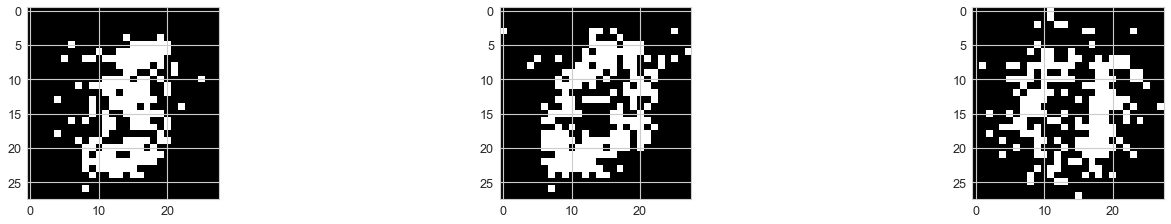

End of epoch 2
Bit error rate: 11.74%


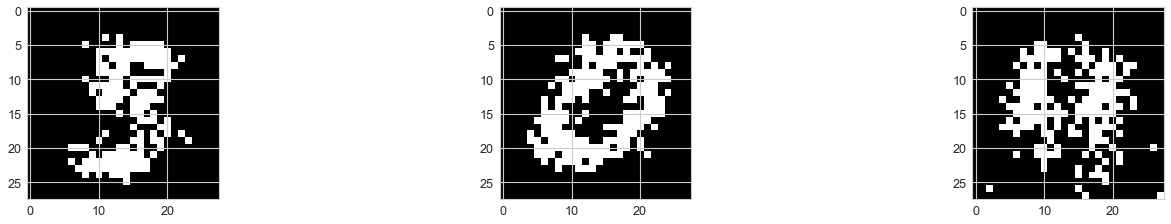

End of epoch 3
Bit error rate: 10.72%


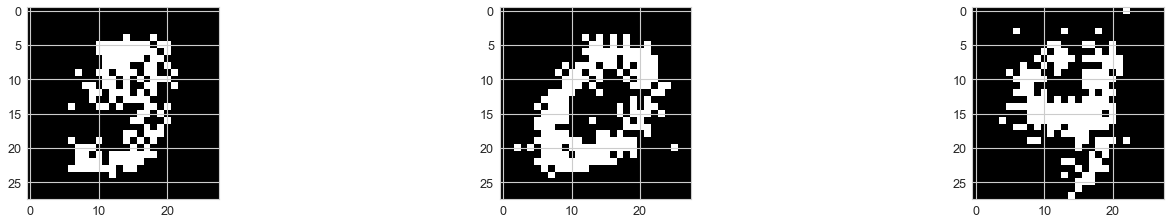

End of epoch 4
Bit error rate: 10.07%


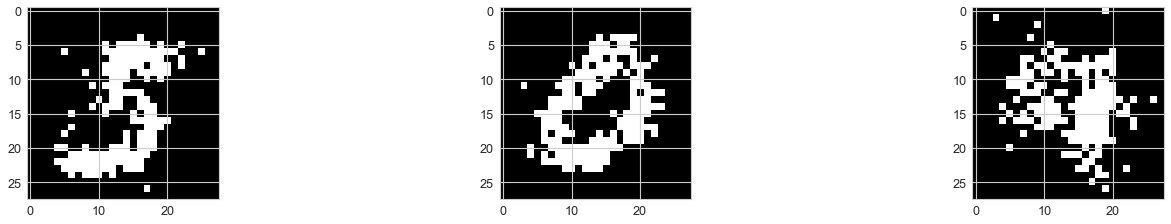

End of epoch 5
Bit error rate: 9.60%


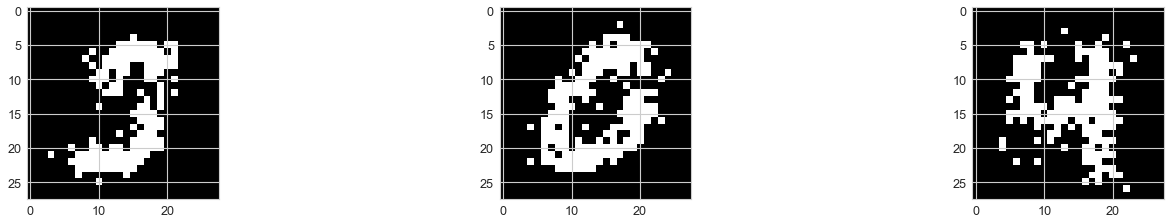

End of epoch 6
Bit error rate: 9.23%


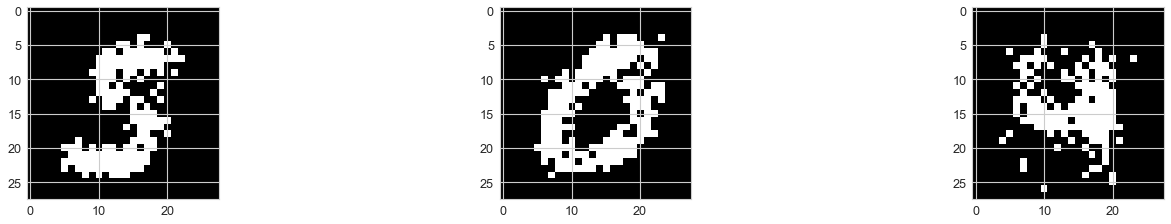

End of epoch 7
Bit error rate: 8.93%


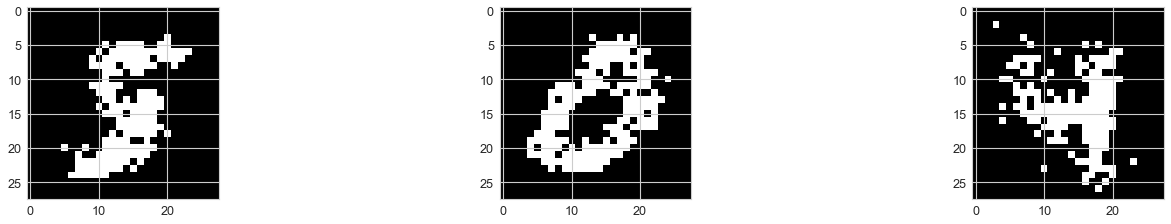

End of epoch 8
Bit error rate: 8.69%


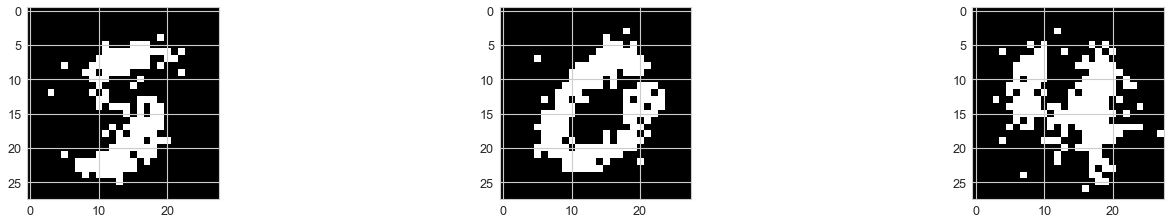

End of epoch 9
Bit error rate: 8.49%


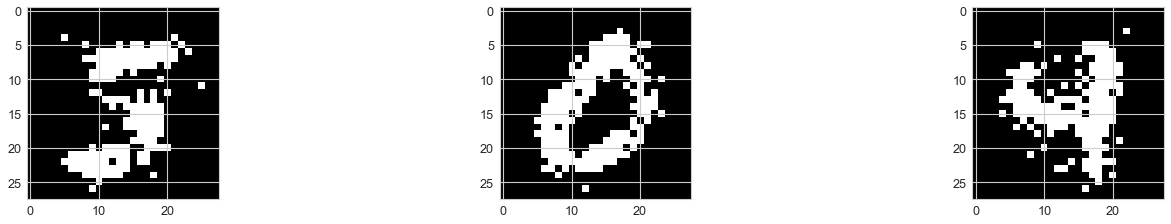

End of epoch 10
Bit error rate: 8.30%


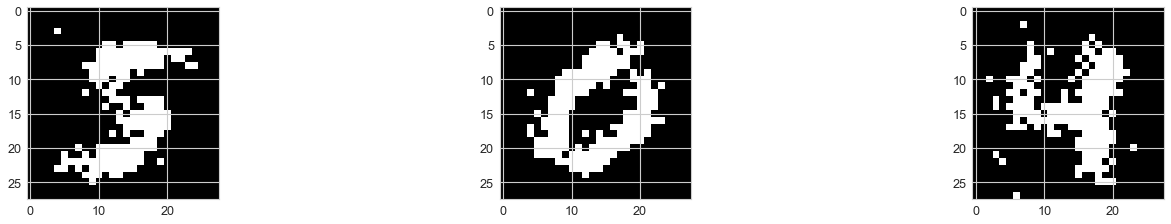

End of epoch 11
Bit error rate: 8.16%


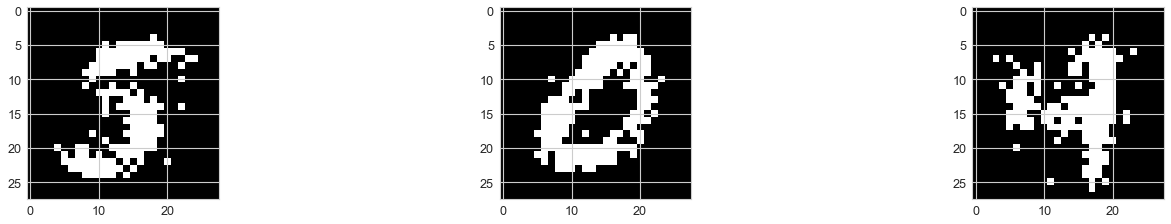

End of epoch 12
Bit error rate: 8.01%


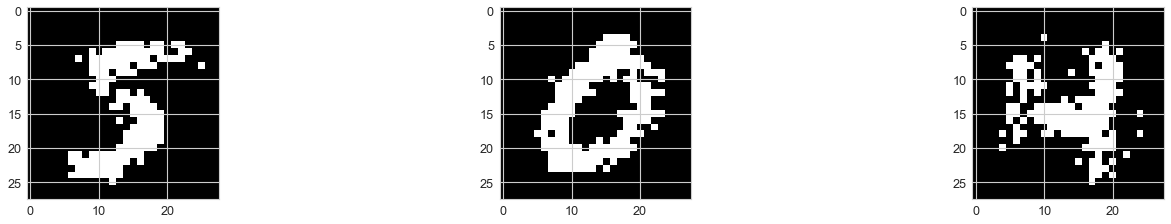

End of epoch 13
Bit error rate: 7.89%


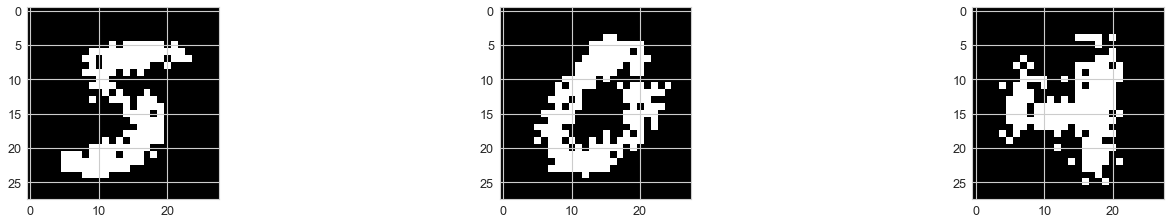

End of epoch 14
Bit error rate: 7.78%


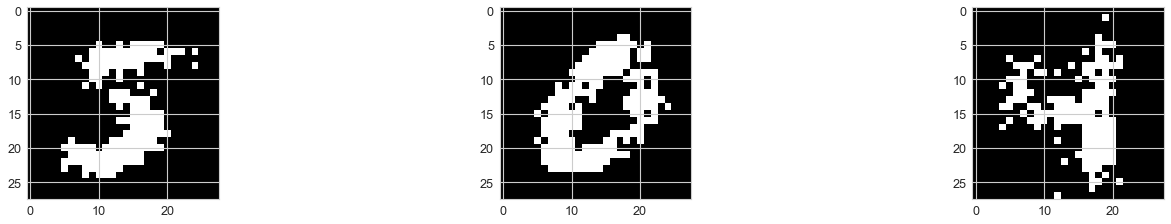

End of epoch 15
Bit error rate: 7.68%


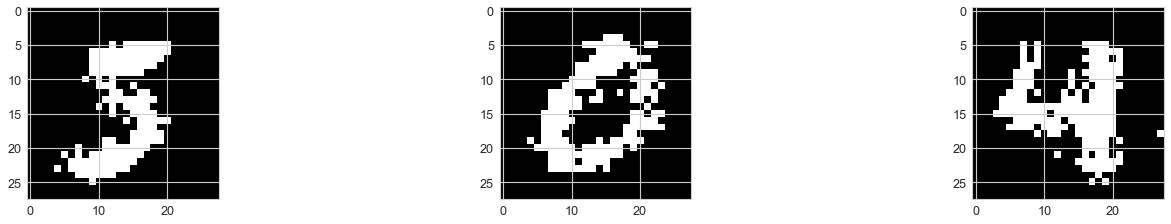

End of epoch 16
Bit error rate: 7.59%


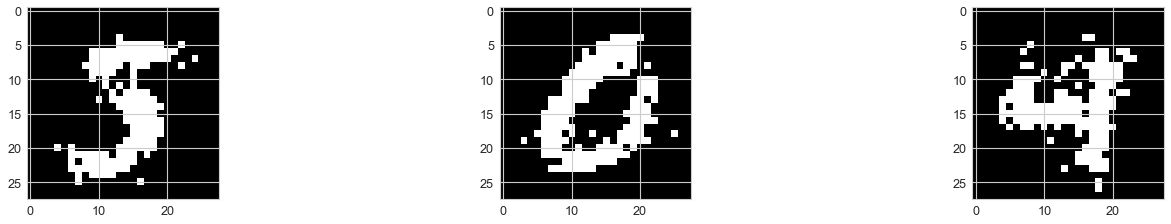

End of epoch 17
Bit error rate: 7.51%


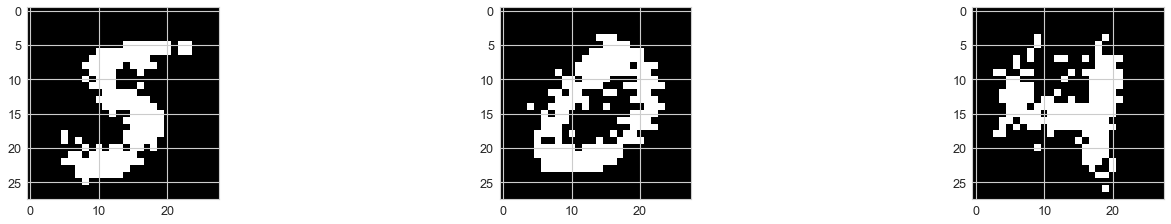

End of epoch 18
Bit error rate: 7.43%


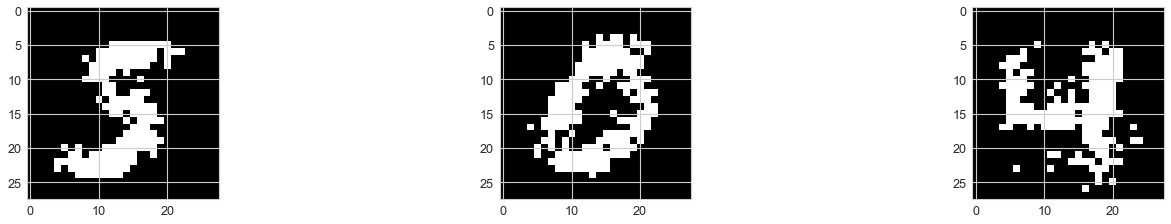

End of epoch 19
Bit error rate: 7.36%


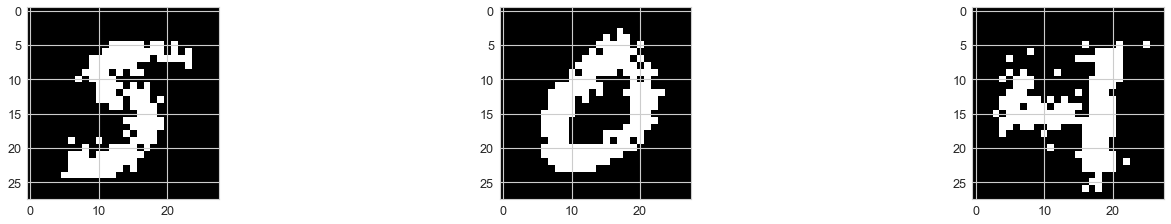

End of epoch 20
Bit error rate: 7.28%


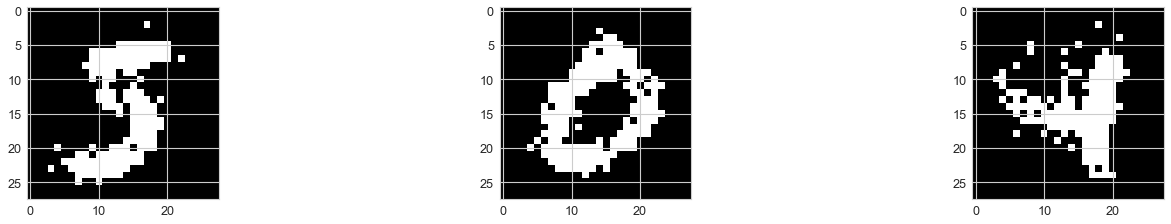

End of epoch 21
Bit error rate: 7.23%


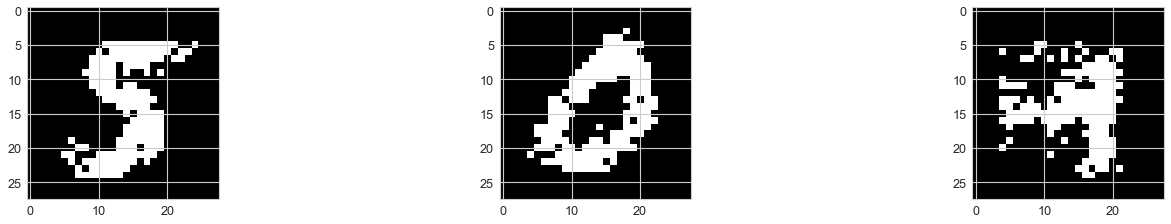

End of epoch 22
Bit error rate: 7.18%


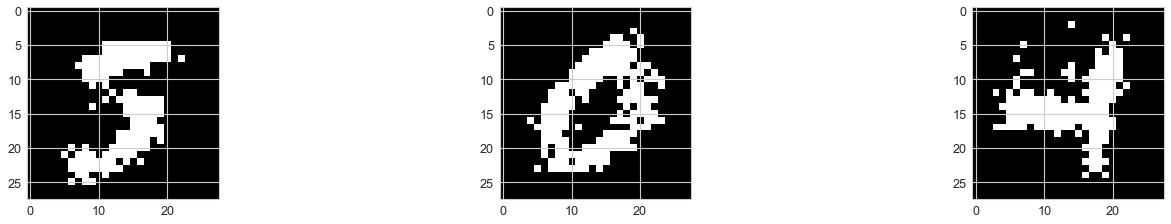

End of epoch 23
Bit error rate: 7.13%


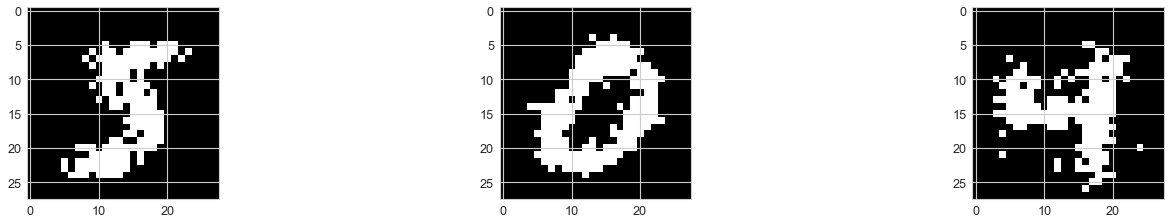

End of epoch 24
Bit error rate: 7.07%


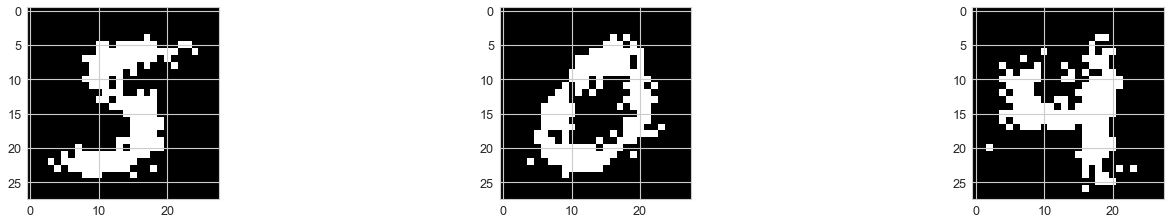

In [3]:
rbm = RBM(flat_train_X, h_size = 80, max_epochs = 24, batch_learning_rate = 2e-2, momentum = 0.9)
rbm.train()

Here I saved weights and biases in order not to retrain the same network every time and retrieve prevoiusly computed values.

In [4]:
with open('trained_RBM.pkl', 'wb') as file:
    pickle.dump([rbm.weights, rbm.bias_v, rbm.bias_h], file)

#### 1bis. Retrieve previously computed weights

In [3]:
with open('trained_RBM.pkl', 'rb') as file:
    [w, b, c] = pickle.load(file)
    rbm = RBM(flat_train_X, init_weights=w, init_bias_v=b, init_bias_h=c)

#### 2. Encode images

In [6]:
new_train_X = [rbm.encode(flat_train_X[i])[1] for i in range(len(flat_train_X))]
new_test_X = [rbm.encode(flat_test_X[i])[1] for i in range(len(flat_test_X))]

#### 3. Train classifier
I chose the Support Vector Classifier model from the sklearn library. The accuracy_score metric is the percentage of labels matching exactly the ground truth in the test set. 

In [17]:
def train_classifier(training_set, training_labels, test_set, test_labels):
    model = SVC()
    model.fit(training_set, training_labels)
    predictions = model.predict(test_set)
    score = accuracy_score(test_labels, predictions)
    print(f"Accuracy score: {'{:.2f}%'.format(100*score)} ({int(score*len(test_set))} out of {len(test_set)})")
    return predictions

In [18]:
# pure mnist dataset
predicted_y_v = train_classifier(flat_train_X, train_y, flat_test_X, test_y)

Accuracy score: 97.92% (9792 out of 10000)


In [19]:
# encoded dataset 
predicted_y_h = train_classifier(new_train_X, train_y, new_test_X, test_y)

Accuracy score: 95.70% (9570 out of 10000)


### Observations
#### Confusion matrix
The main misclassification performed by both classifier is the 4-9 error, but that's understandable given the fact that digits are often similar when badly written. Other common errors are 1-7 and 3-8, although on a lower frequency, and these too are ok because these pairs of digits can be very similar for bad handwriters.

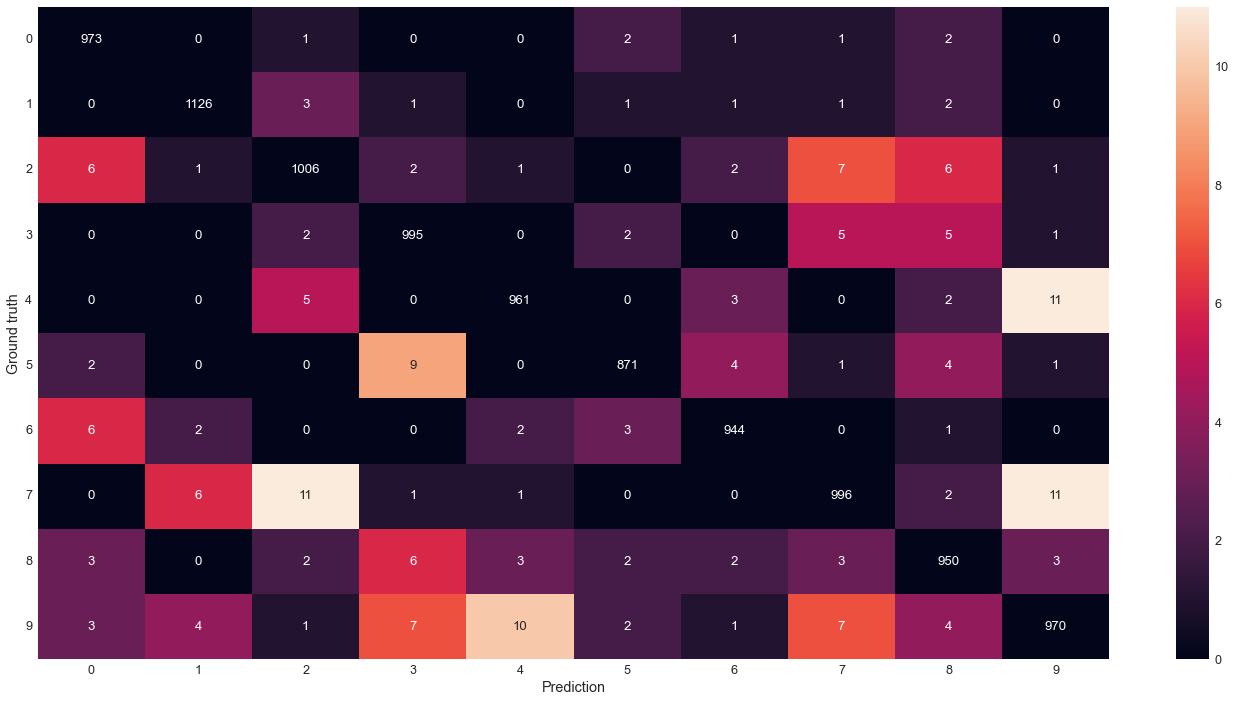

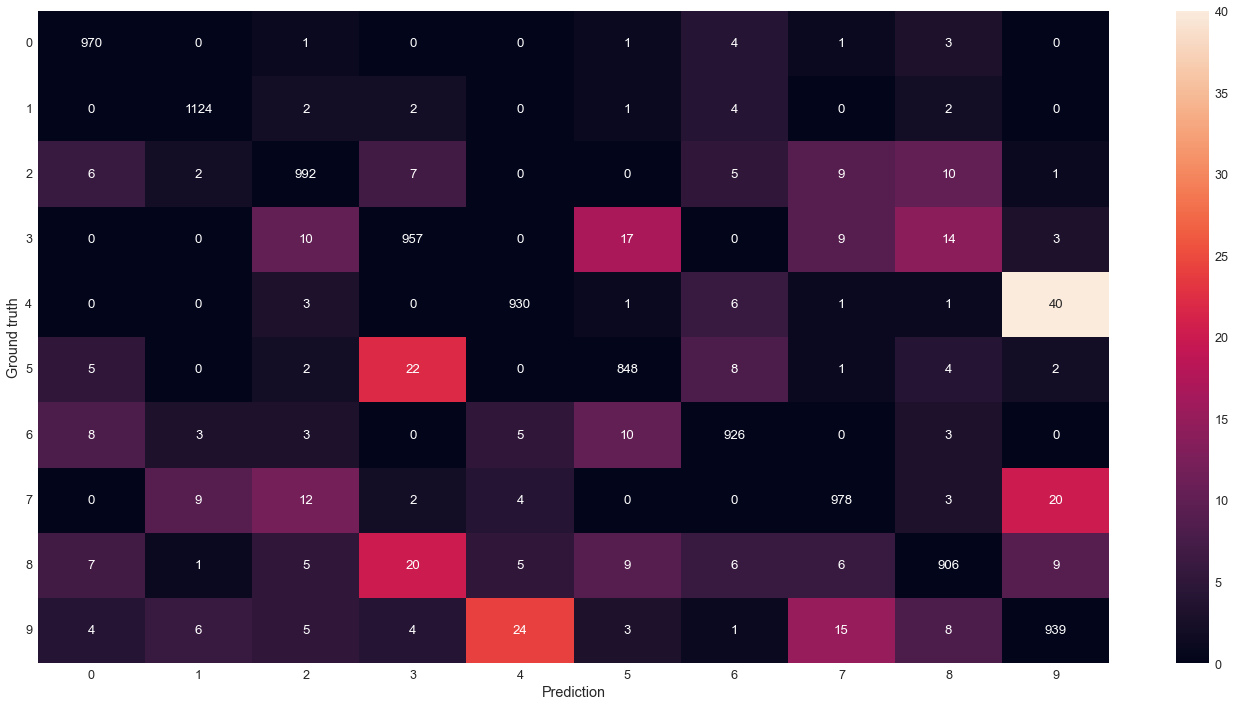

In [20]:
# prints a confusion matrix (distribution of errors)
def confusion_matrix(test_set, predictions):
    cm = np.zeros((10,10)).astype(int)
    cm_nd = np.zeros((10,10)).astype(int)
    for i, correct_y in enumerate(test_set):
        cm[correct_y, predictions[i]] += 1
        if correct_y != predictions[i]:
            cm_nd[correct_y, predictions[i]] += 1

    ax = seaborn.heatmap(
        cm_nd,
        annot=cm,
        fmt='d',
        xticklabels=range(0,10),
        yticklabels=range(0,10)
    )

    plt.yticks(rotation=0)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground truth')

    plt.show()

    
confusion_matrix(test_y, predicted_y_v)
confusion_matrix(test_y, predicted_y_h)

#### On the choice of training parameters
I followed the suggestions in Hinton's paper, and I tried about 15 different combinations of parameters, focusing on learning rate, number of epochs and number of hidden units.

The 80 hidden variables - 24 epochs setting turned out to be the best by far (almost 96% accuracy versus no more than 93% with any other combo I trained), so I sticked with it and did not add any fancy Machine Learning trick, because I thought it would be better for it to be simpler but also well performing, instead of trying to get to 96.1% with one out of 100 other combos or with hundreds of epochs. I may have had small room for improvement, but I was happy with my results and kept them.

### Further considerations
#### What if...
...we feed the RBM a black picture? A white picture? A checkered pattern?
I created an array with these 3 images and iterated the encode/decode step 1000 times, printing the result every 50 iterations.

Iteration 1


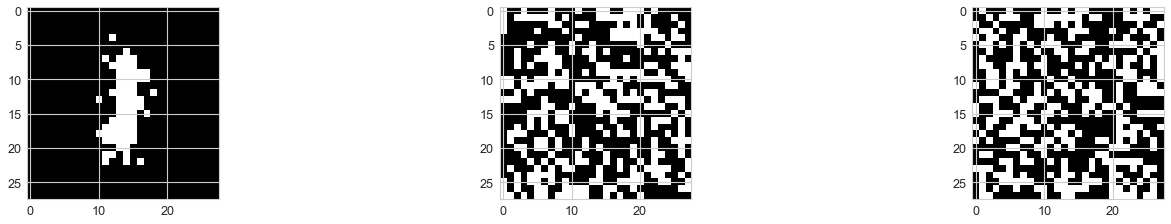

Iteration 50


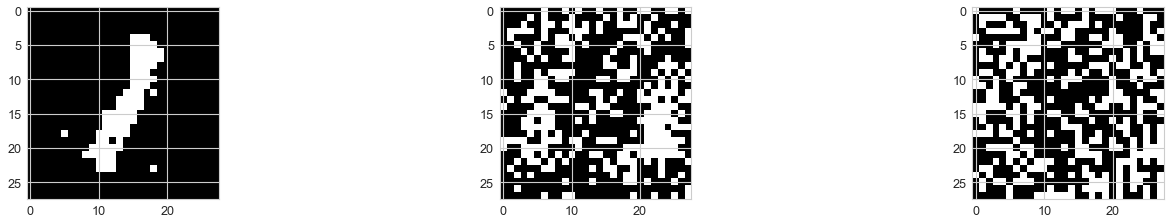

Iteration 100


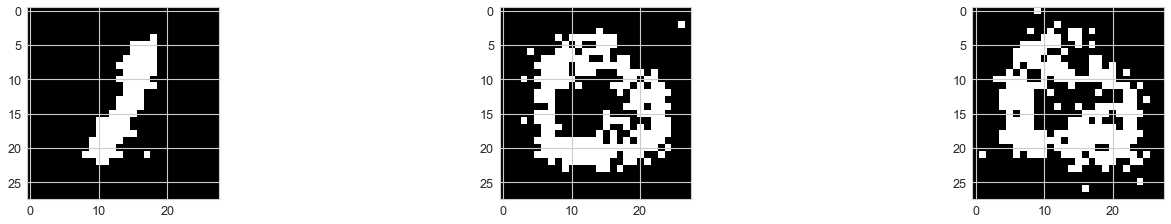

Iteration 150


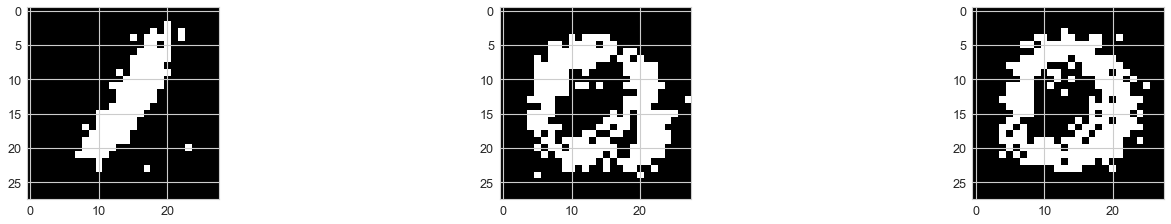

Iteration 200


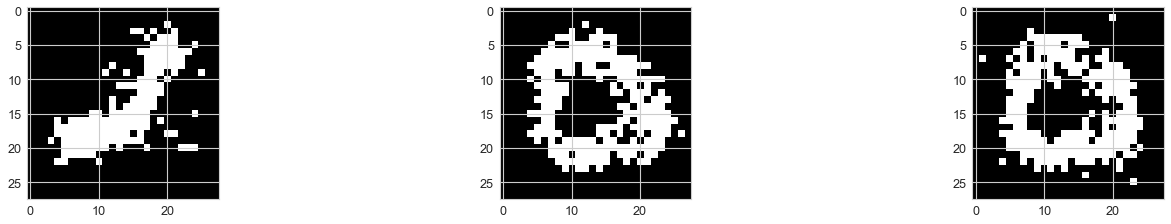

Iteration 250


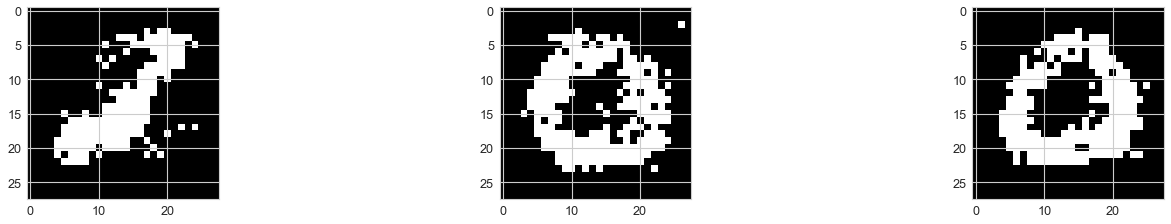

Iteration 300


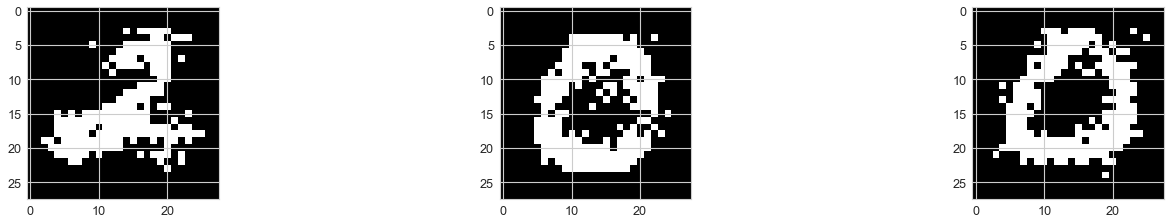

Iteration 350


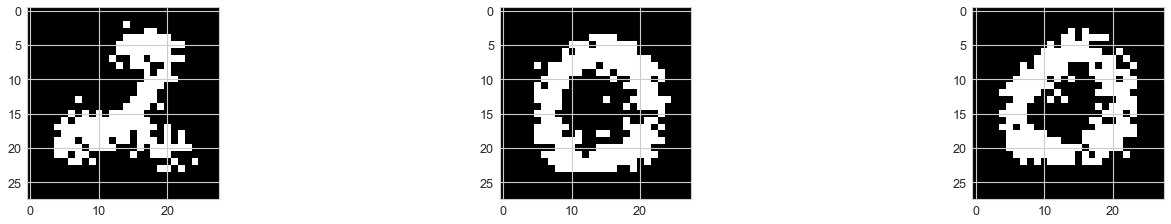

Iteration 400


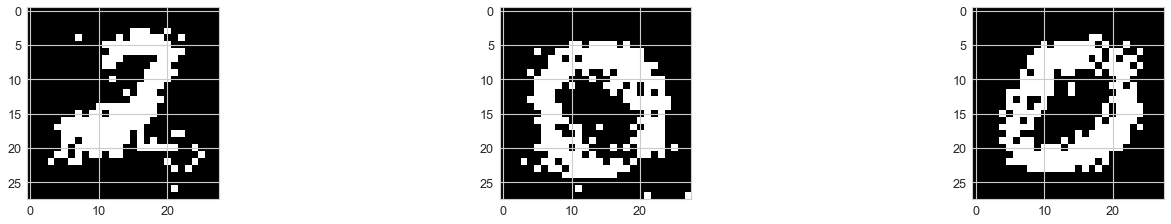

Iteration 450


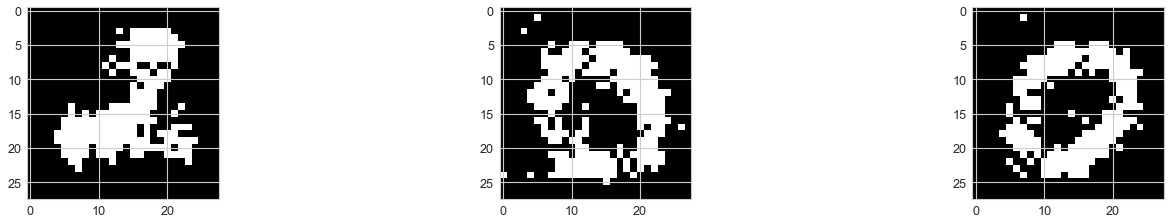

Iteration 500


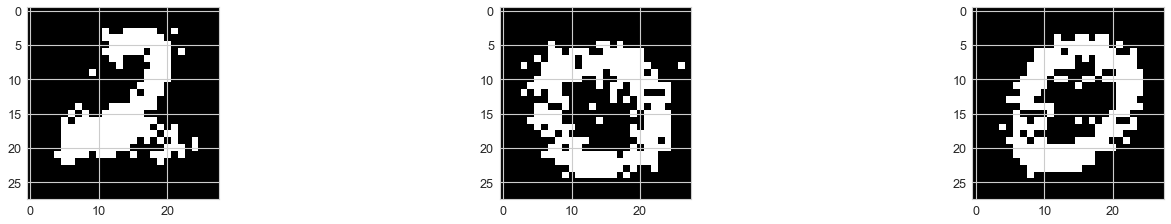

Iteration 550


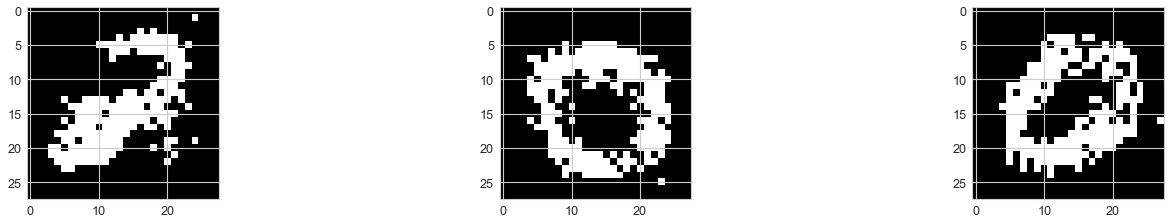

Iteration 600


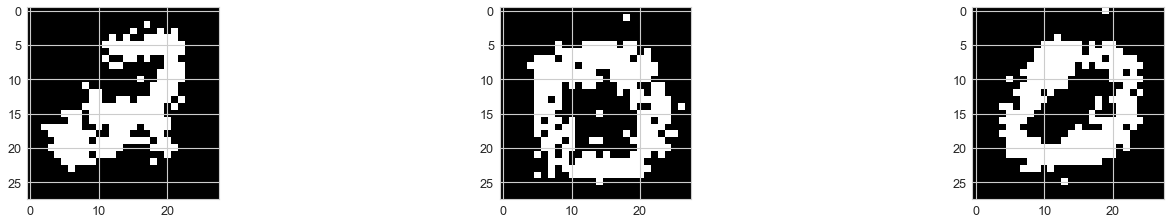

Iteration 650


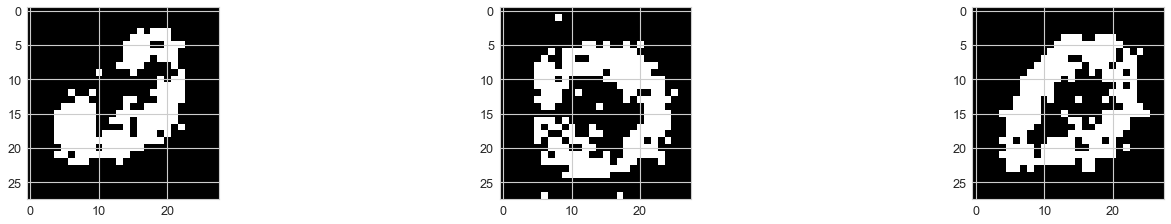

Iteration 700


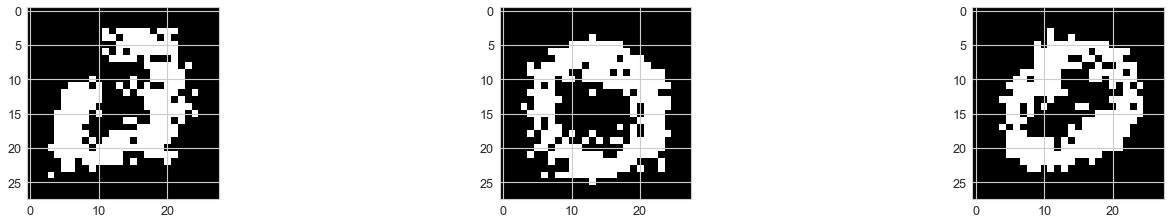

Iteration 750


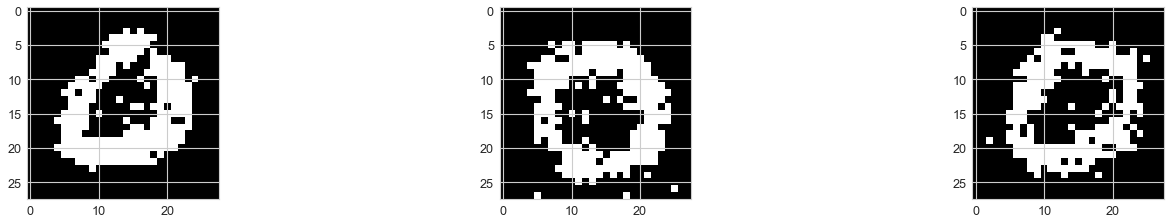

Iteration 800


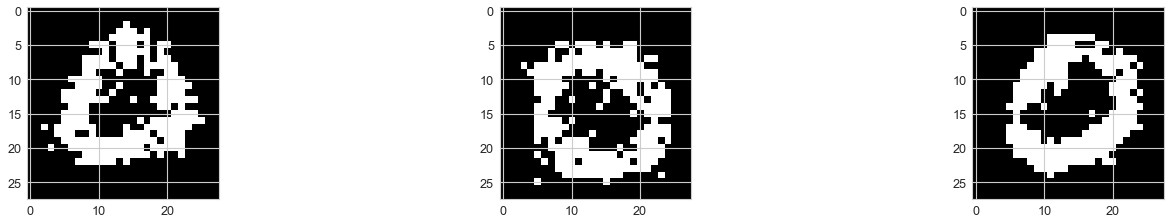

Iteration 850


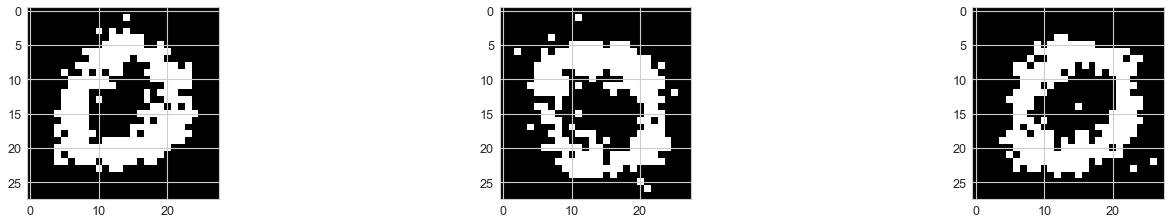

Iteration 900


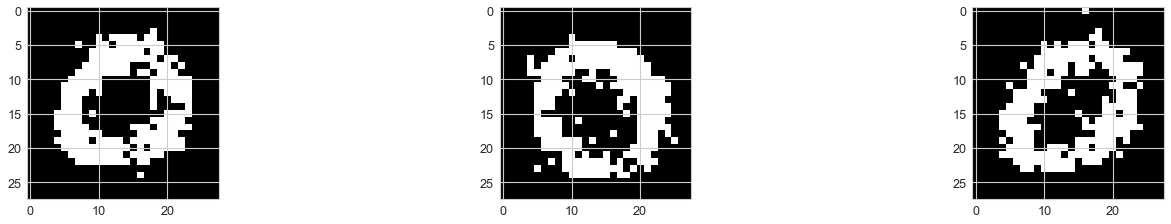

Iteration 950


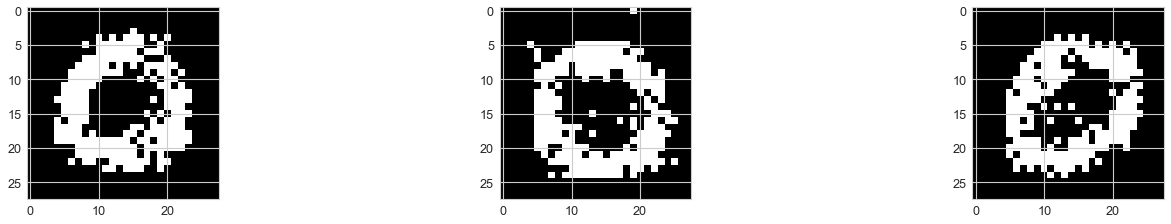

Iteration 1000


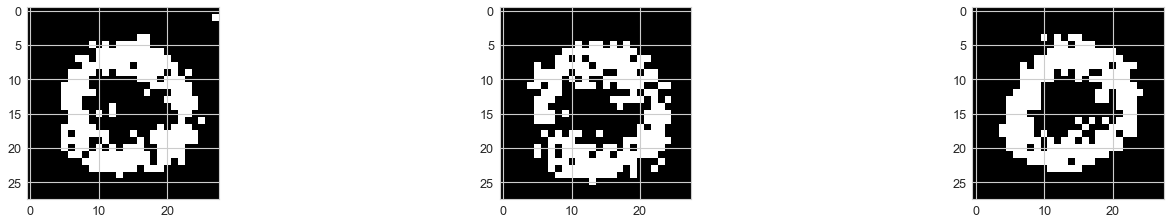

In [21]:
def limit_reconstruction(images, iterations=1000, checkpoint=50):
    for i in range(iterations):
        images = [rbm.reconstruct(image) for image in images]
        if i%checkpoint == checkpoint-1 or i == 0:
            print(f"Iteration {i+1}")
            for j in range(len(images)):
                plt.subplot(330 + 1 + j)
                plt.imshow(np.reshape(images[j], (28,28)), cmap=plt.get_cmap('gray'))
            plt.show()
            

black = np.zeros(784)
white = np.ones(784)
checkered = np.concatenate(list(zip(np.zeros(392), np.ones(392))))

patterns = [black, white, checkered]

limit_reconstruction(patterns)

The white and checkered images took about 250 iterations to become something meaningful, i.e. a 0, which never changed through the remaining 750 steps.

The black one was way more interesting: I tried executing that code around 40 times and every time a digit clearly showed up it remained more or less the same through all 1000 iterations. If no digit emerges in the first few hundred iterations, then that shape converges to a 0, and that happens about 50% of the time. I have seen at least one example of every digit, so I think the encoder does a nice job preserving a number whenever it manifests.

To check the truth value of this statement, I applied the same 10 lines of code to a sample for each digit in the MNIST dataset.

Iteration 1


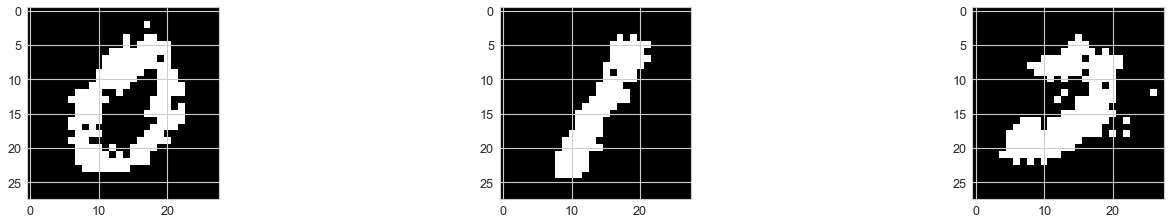

Iteration 50


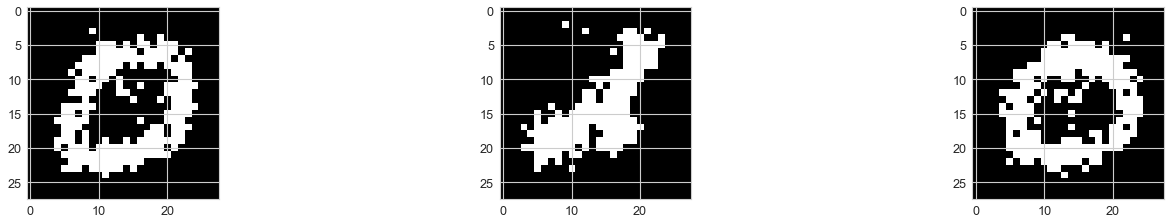

Iteration 100


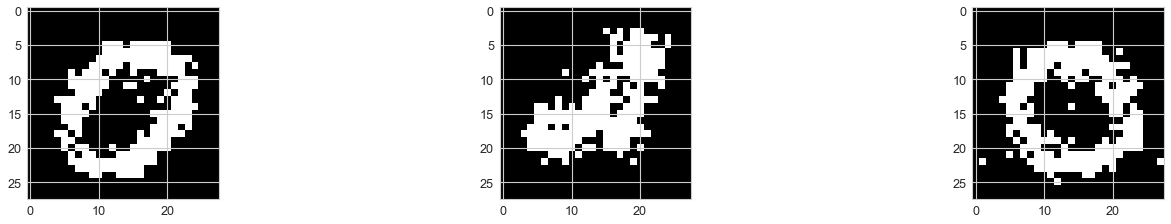

Iteration 150


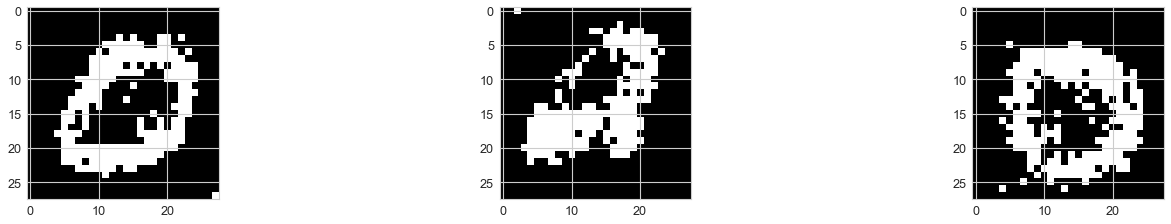

Iteration 200


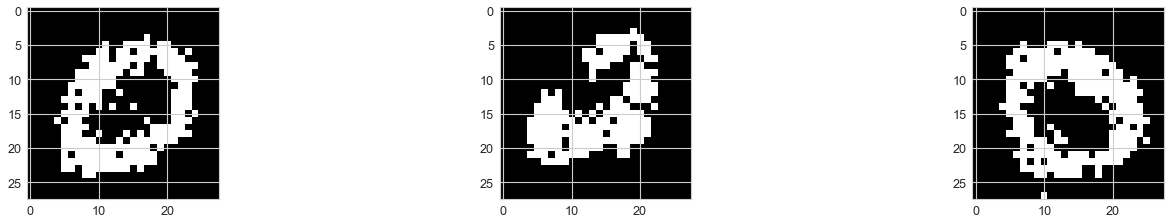

Iteration 250


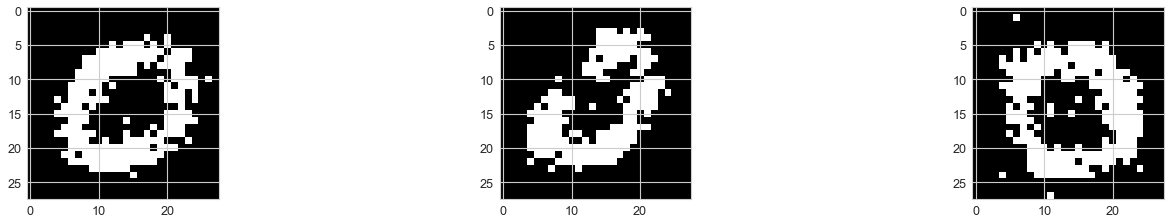

Iteration 300


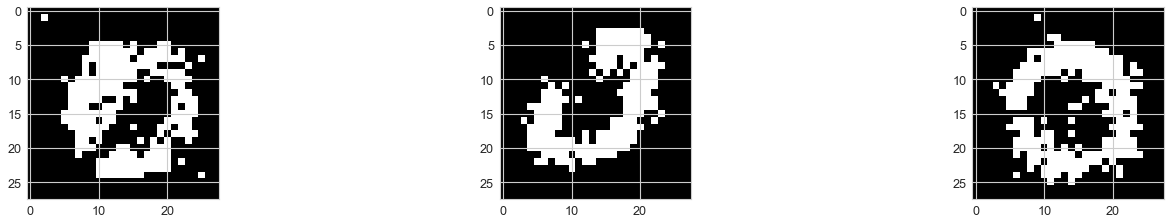

Iteration 350


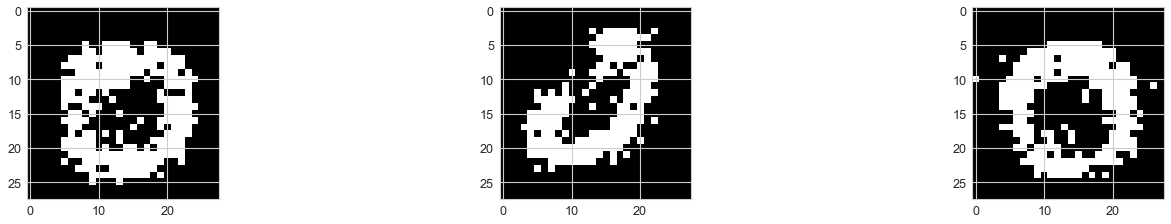

Iteration 400


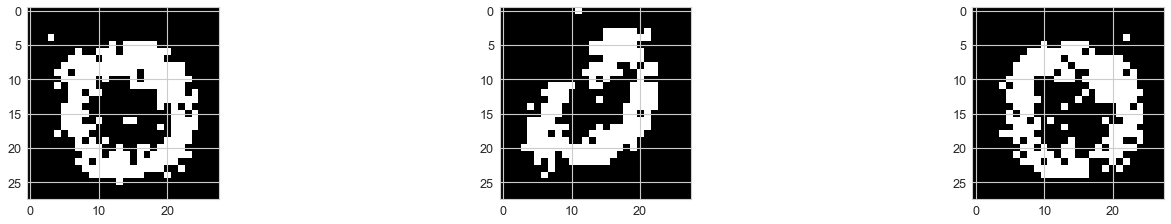

Iteration 450


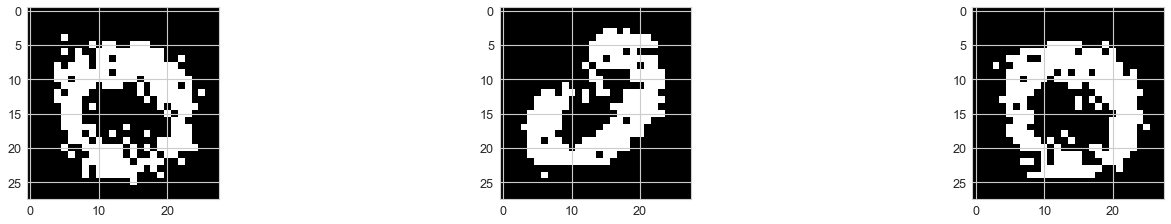

Iteration 500


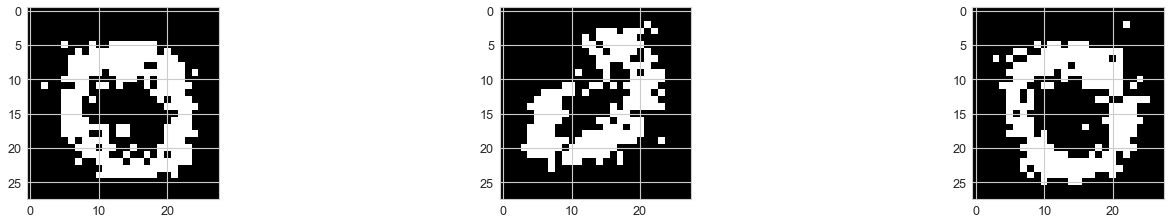

Iteration 550


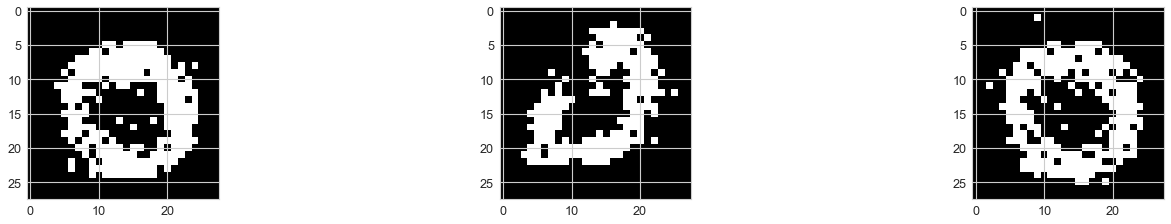

Iteration 600


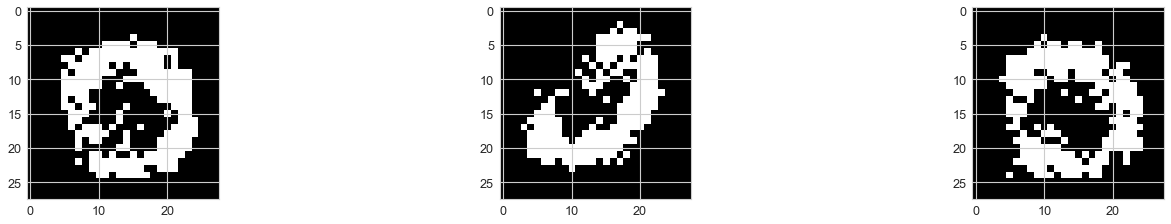

Iteration 650


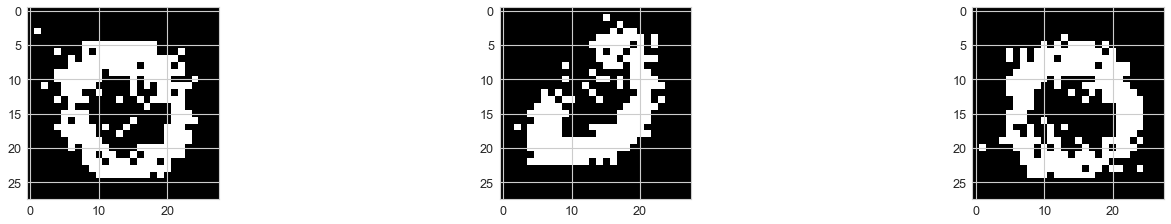

Iteration 700


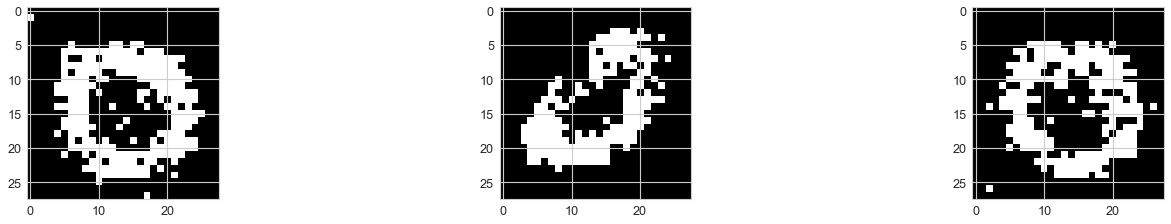

Iteration 750


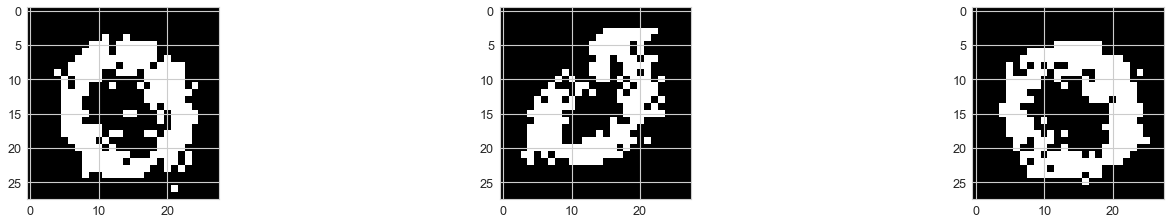

Iteration 800


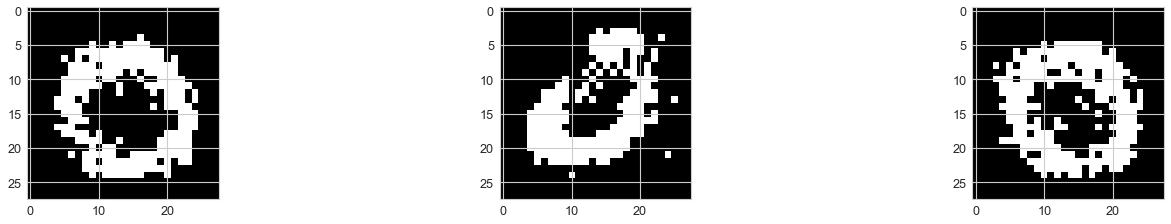

Iteration 850


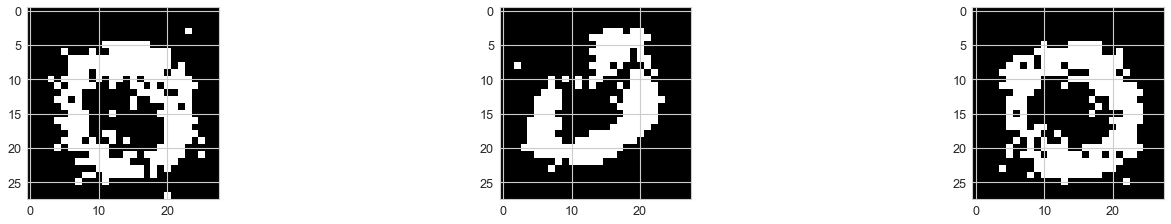

Iteration 900


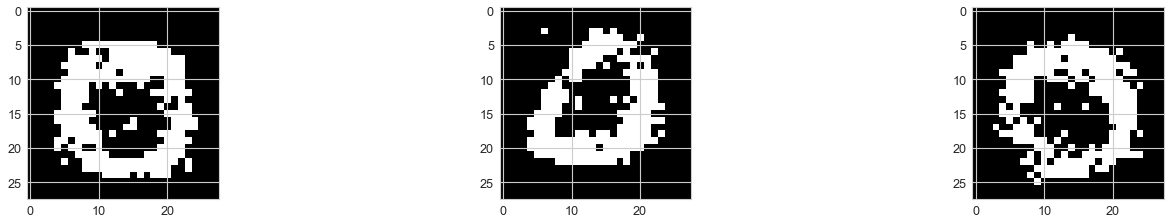

Iteration 950


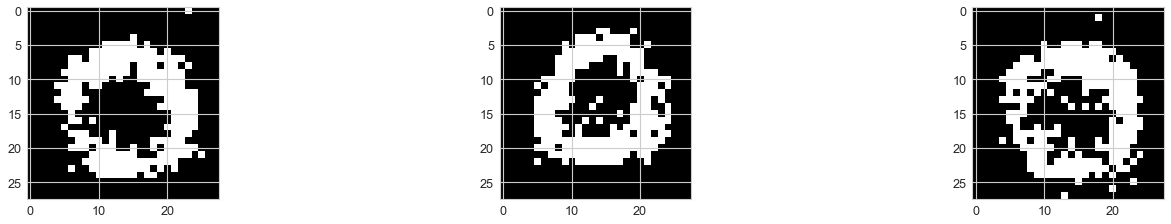

Iteration 1000


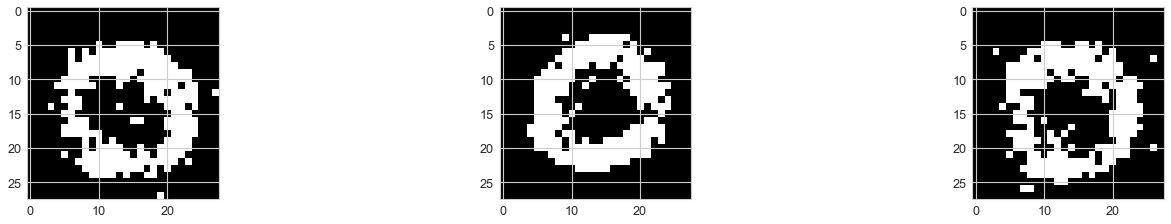

In [22]:
digits = []
for i in range(3):
    digits.append(flat_train_X[np.where(train_y == i)][0])

limit_reconstruction(digits)

Iteration 1


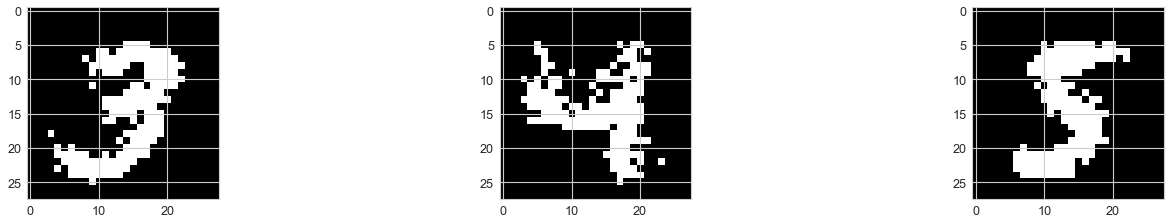

Iteration 50


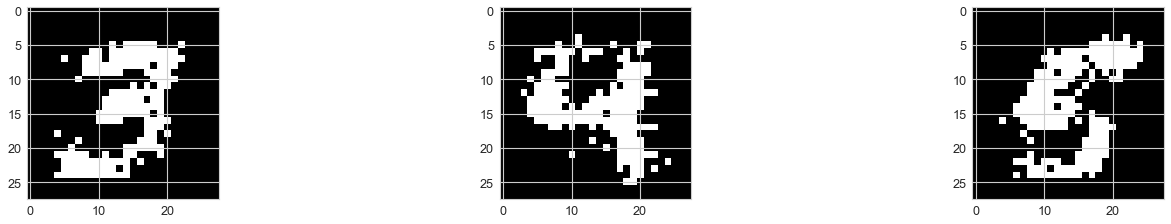

Iteration 100


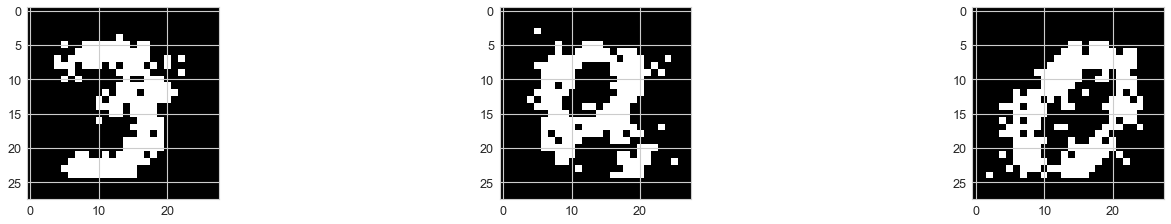

Iteration 150


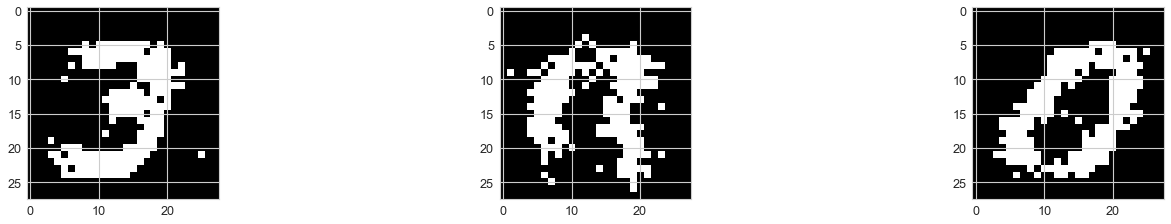

Iteration 200


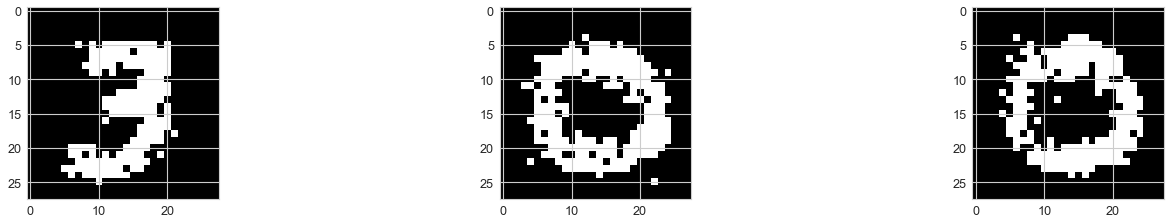

Iteration 250


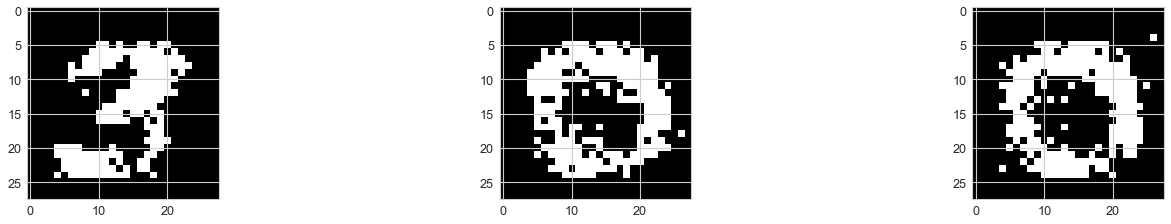

Iteration 300


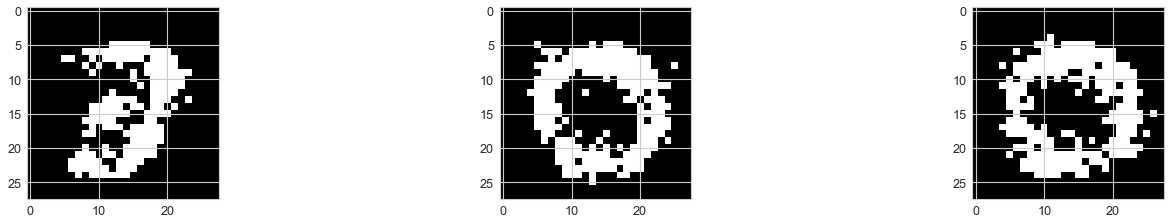

Iteration 350


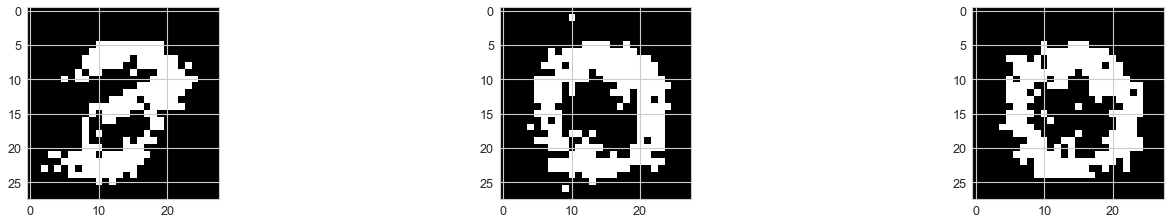

Iteration 400


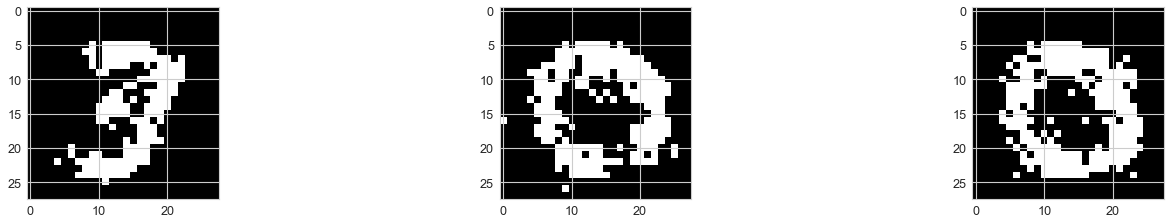

Iteration 450


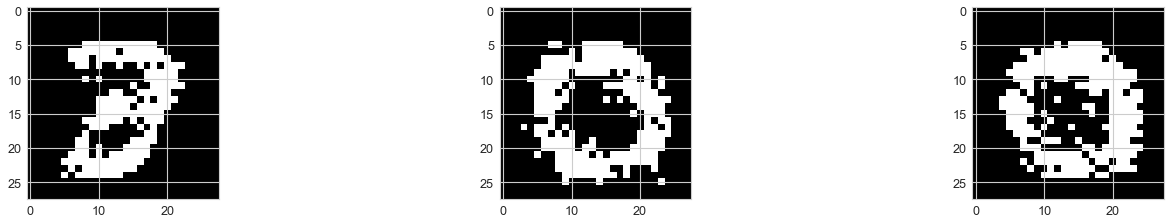

Iteration 500


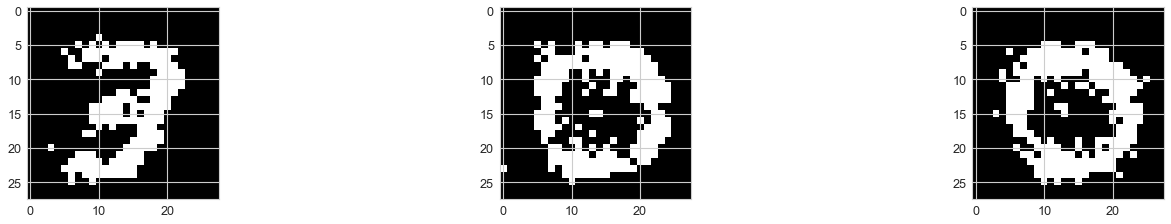

Iteration 550


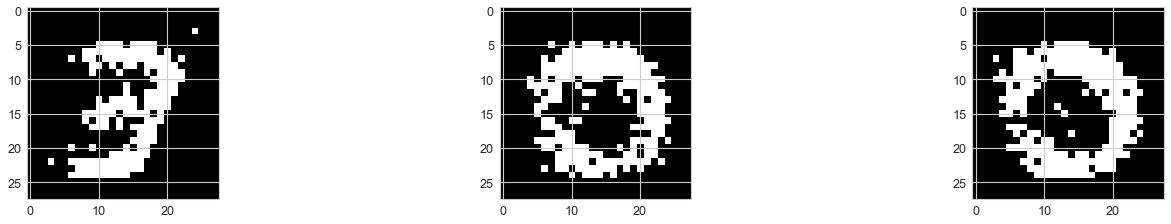

Iteration 600


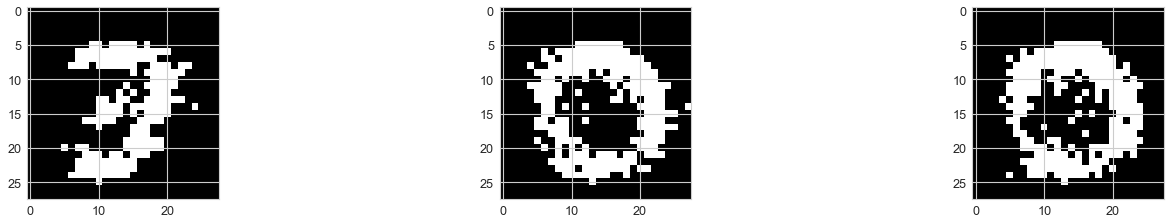

Iteration 650


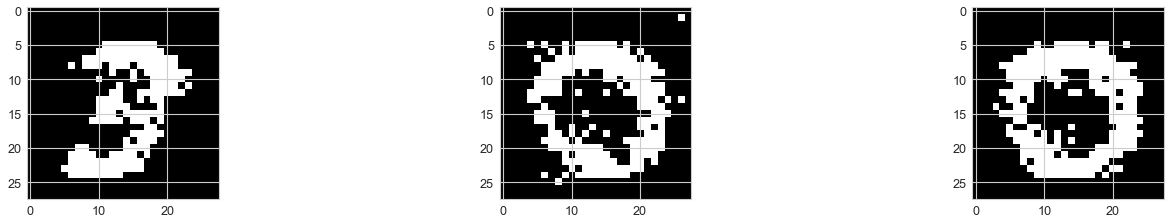

Iteration 700


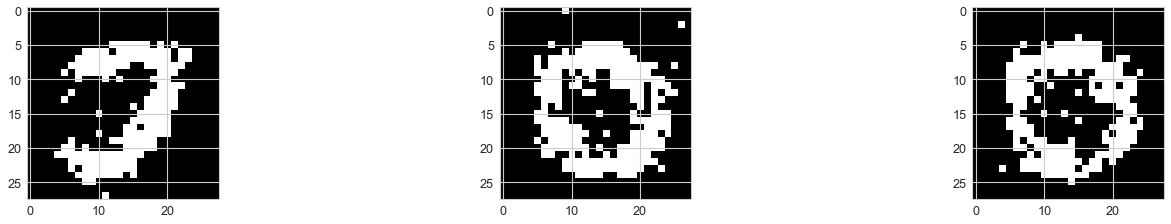

Iteration 750


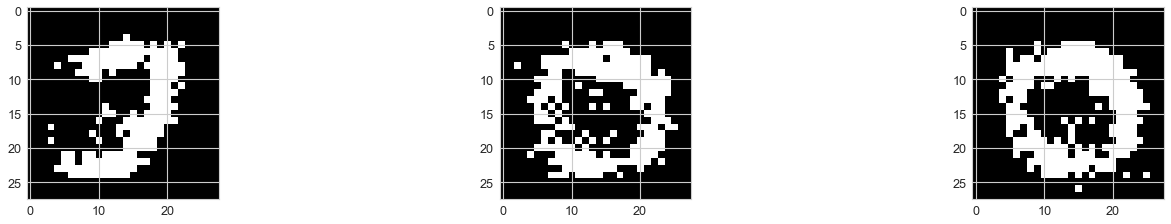

Iteration 800


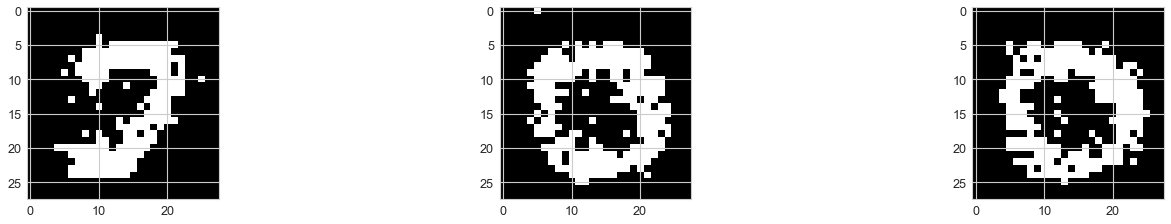

Iteration 850


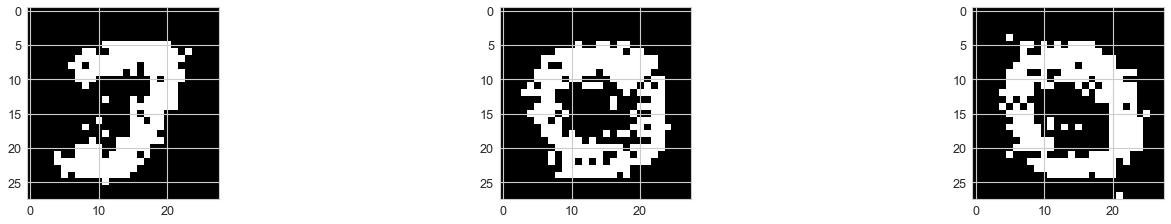

Iteration 900


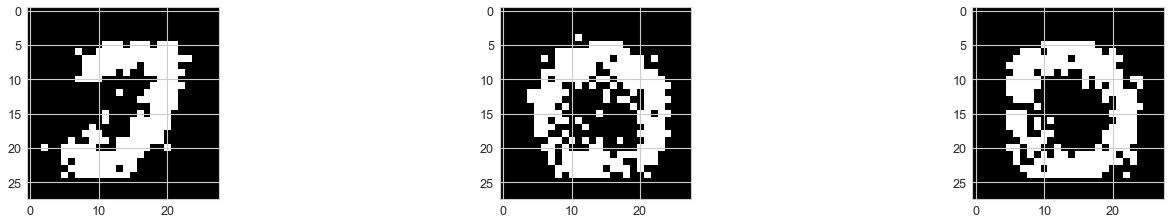

Iteration 950


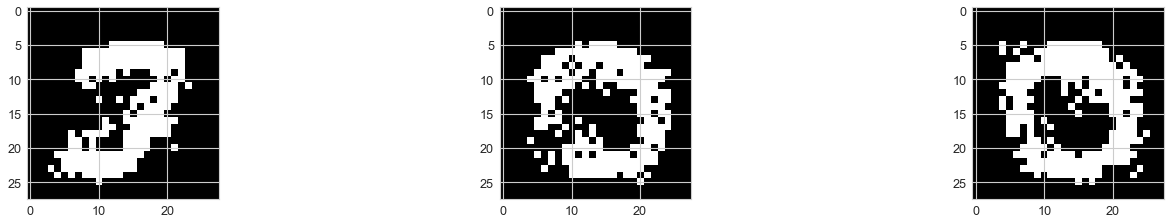

Iteration 1000


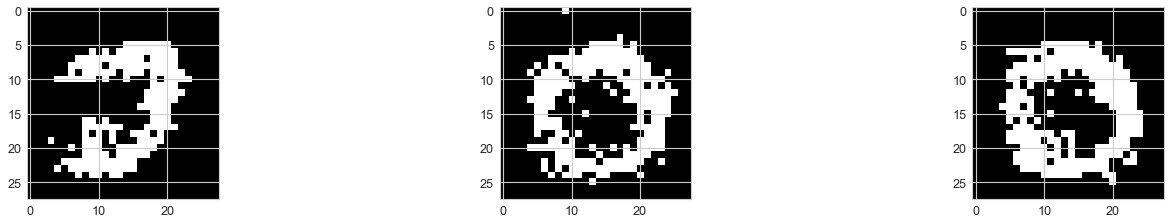

In [23]:
digits = []
for i in range(3,6):
    digits.append(flat_train_X[np.where(train_y == i)][0])

limit_reconstruction(digits)

Iteration 1


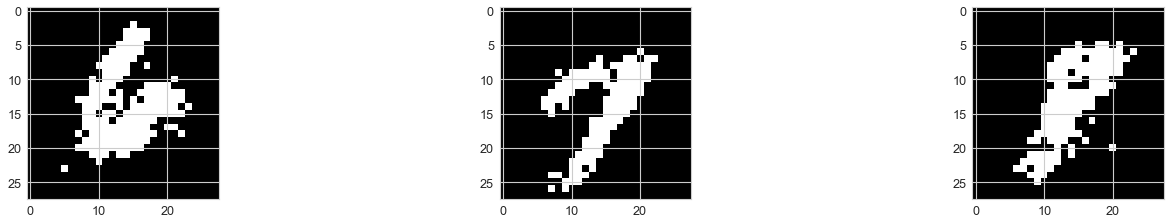

Iteration 50


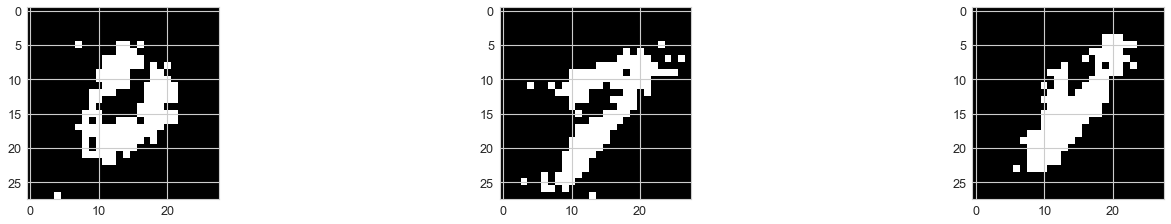

Iteration 100


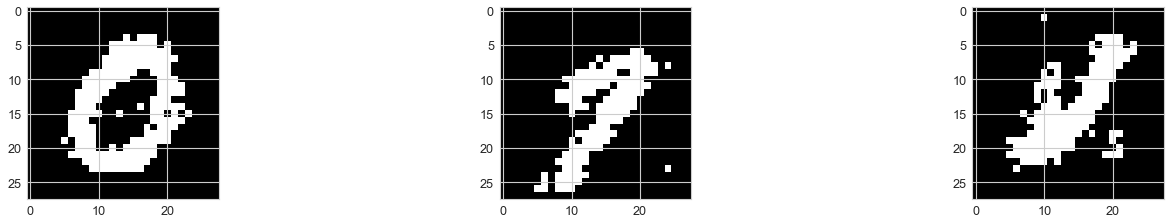

Iteration 150


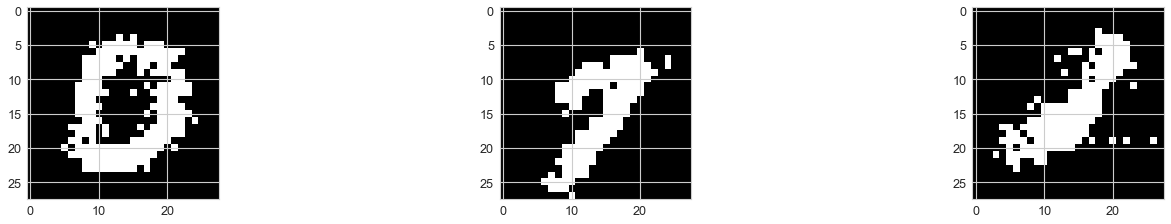

Iteration 200


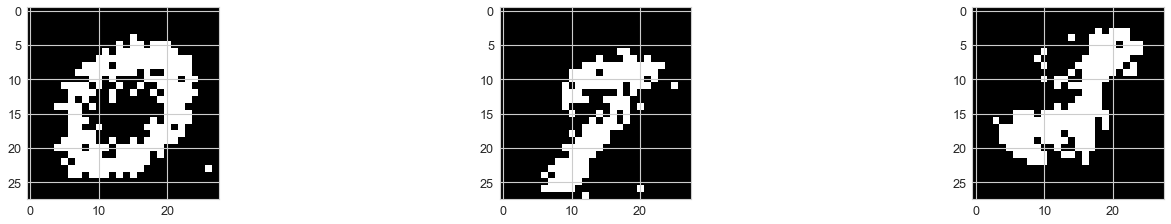

Iteration 250


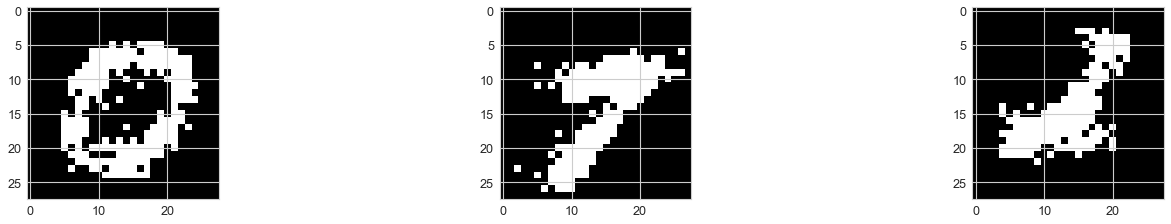

Iteration 300


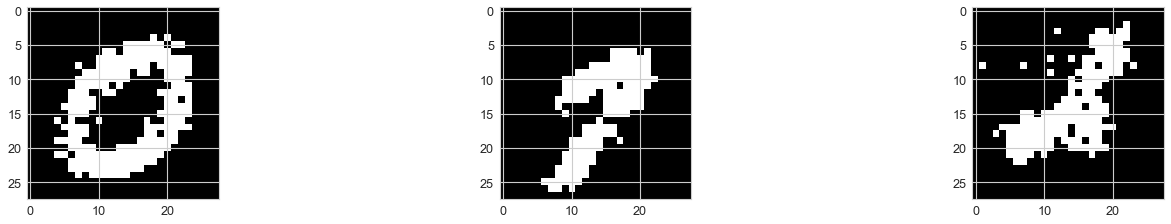

Iteration 350


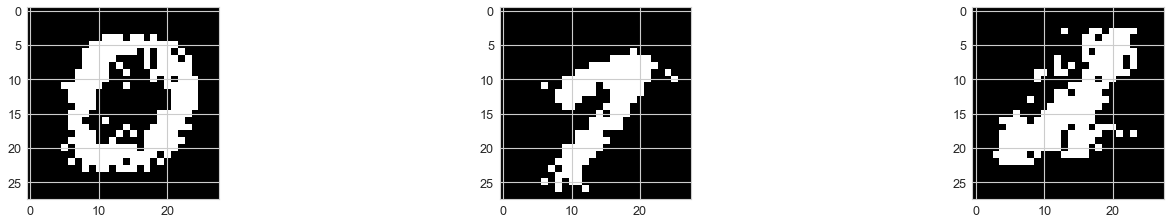

Iteration 400


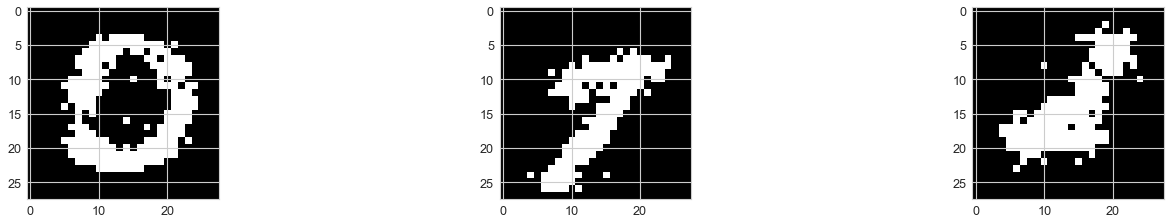

Iteration 450


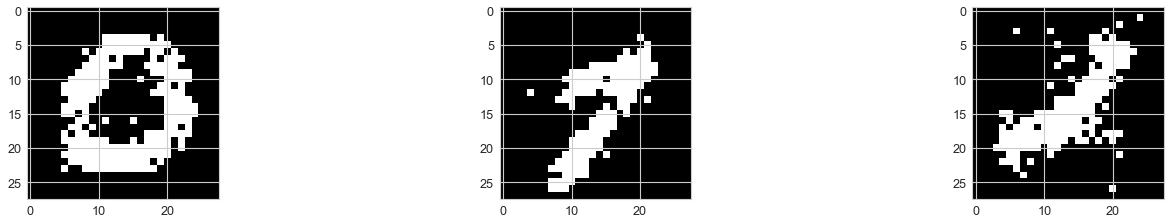

Iteration 500


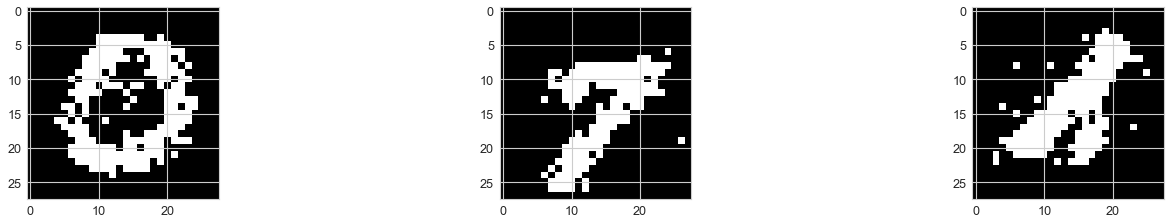

Iteration 550


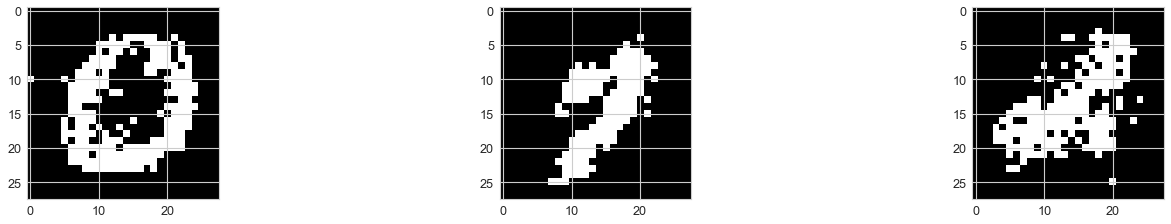

Iteration 600


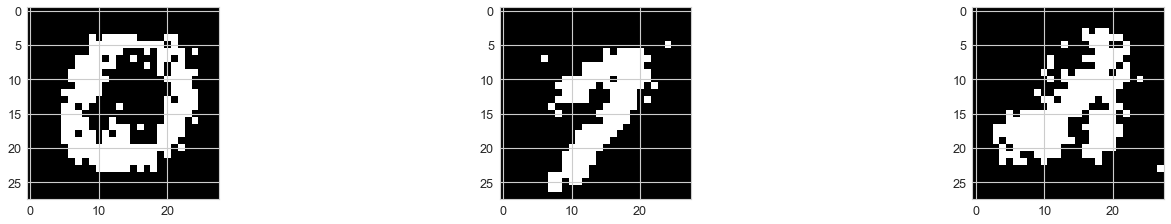

Iteration 650


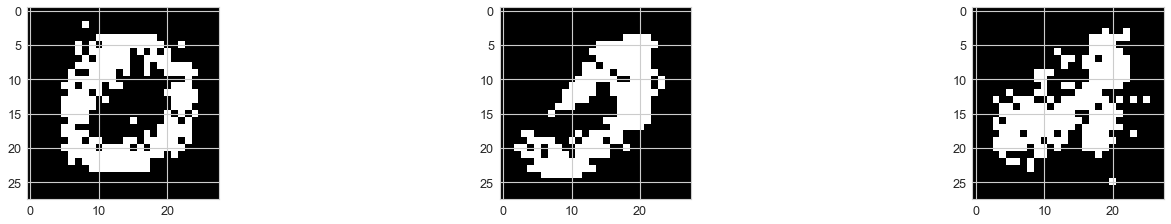

Iteration 700


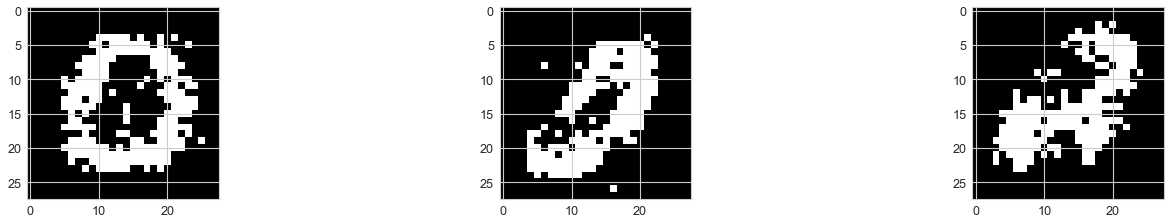

Iteration 750


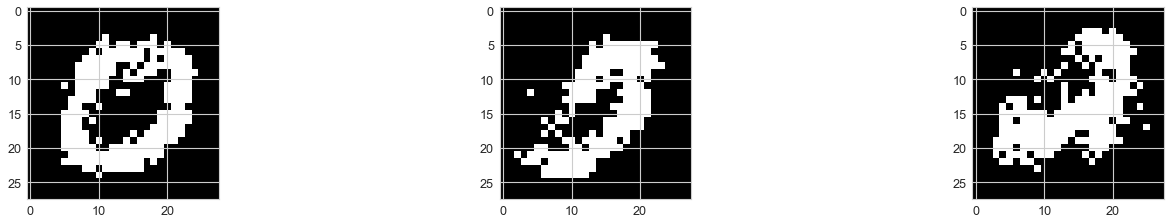

Iteration 800


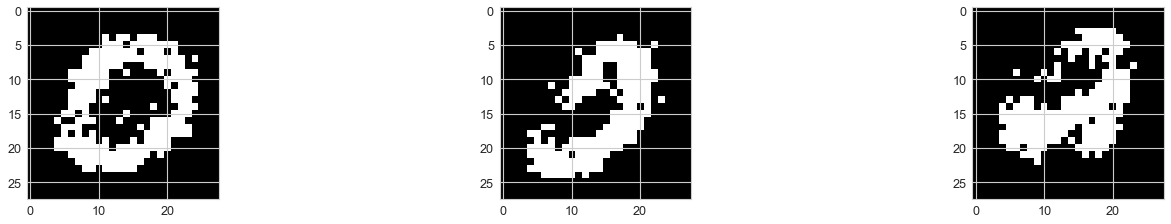

Iteration 850


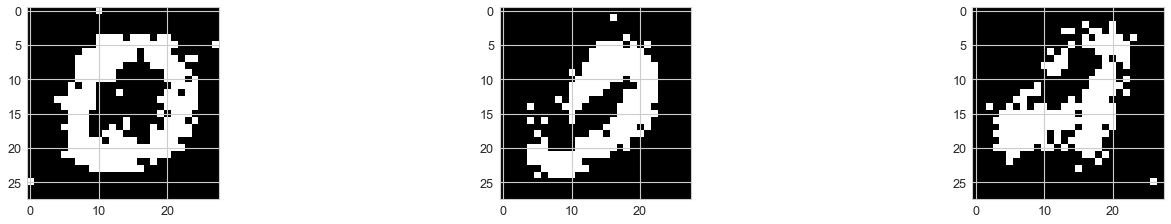

Iteration 900


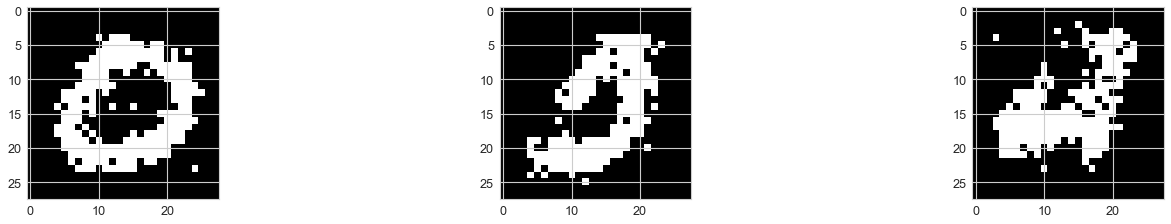

Iteration 950


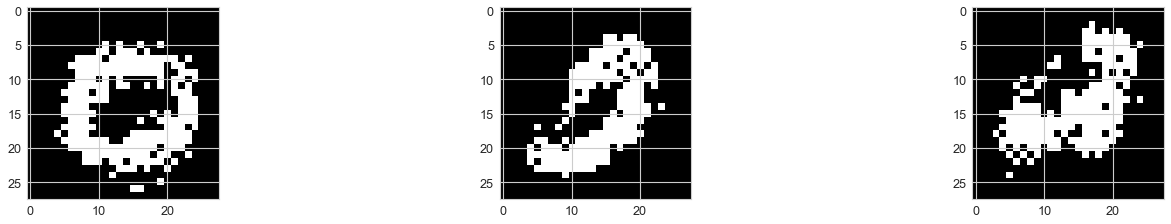

Iteration 1000


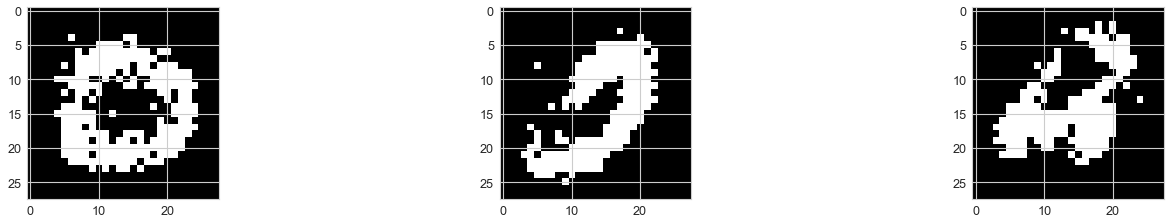

In [24]:
digits = []
for i in range(6,9):
    digits.append(flat_train_X[np.where(train_y == i)][0])

limit_reconstruction(digits)

Iteration 1


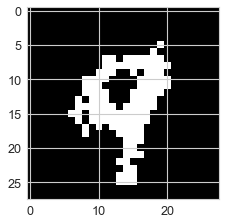

Iteration 50


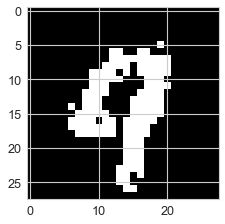

Iteration 100


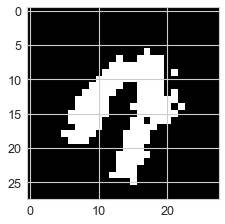

Iteration 150


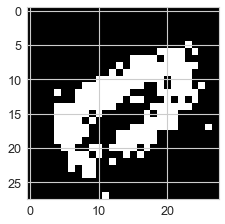

Iteration 200


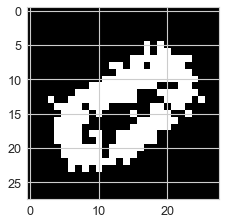

Iteration 250


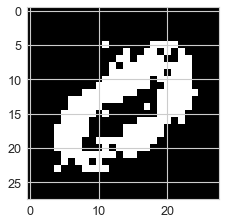

Iteration 300


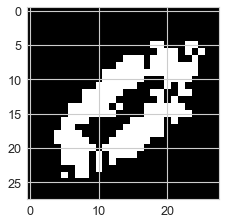

Iteration 350


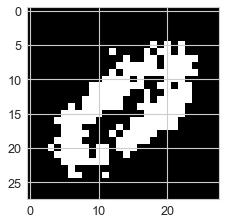

Iteration 400


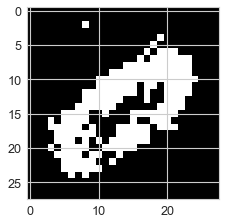

Iteration 450


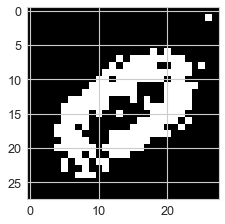

Iteration 500


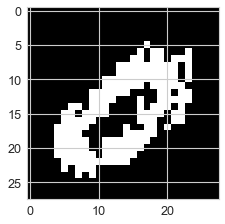

Iteration 550


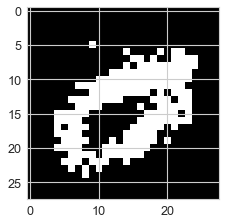

Iteration 600


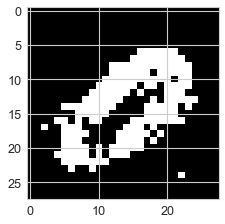

Iteration 650


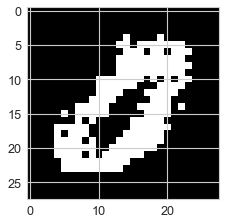

Iteration 700


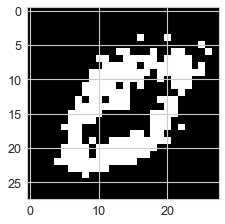

Iteration 750


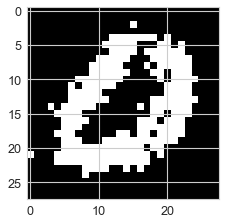

Iteration 800


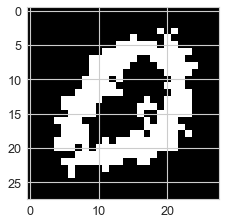

Iteration 850


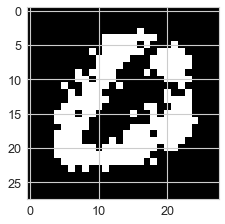

Iteration 900


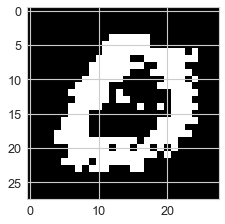

Iteration 950


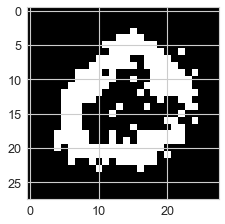

Iteration 1000


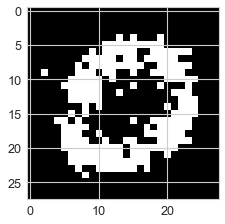

In [25]:
digits = []
digits.append(flat_train_X[np.where(train_y == 9)][0])

limit_reconstruction(digits)

On my first run, 8 out of 9 non-zero digits became 0, and only the 2 survived. I tried again a few times and 2, 7 and 9 were the only numbers able not to turn into a 0 a fair percentage of times (around 1 out of 5). Also, one time the 1 became a 3.

I actually thought that the original images could survive a bit more, but I have been proven wrong, if we can call 20 runs a proof.

#### Possible improvements
The main weakness of my work is that I don't have actual proof for most of my statements, because they are related to code executions that I lost when restarting the kernel and running again every cell. However, I expect other midterms to state very similar things, if not the same, and the largest part of my unproven stuff can be verified in a minute by spamming Ctrl-Enter on the right cell of code. If this is a major issue, that would be obviously understandable and I would like a feedback in order to adapt my work for the next mids.

I could also have dig further into the model reconstruction, feeding some other patterns (stripes etc.) or trying harder with every digit and performing a full multi-trial reconstruction on the whole dataset, while also printing a confusion matrix every 50 iterations or something, but that seemed a bit out of the scope of this midterm.

#### In the end
I had lots of fun trying to make my code work the way I intended, and I was very proud of it the first time I got a flawless run. I'm enjoying these assessments, and I look forward to performing the next one.